In [1]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBIO

import gzip
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from DSSPparser import parseDSSP

import concurrent.futures
import subprocess
import random

import os
import shutil
import gzip
import zipfile
import pickle

import Modules.TORSION2 as TORSION2

from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor, as_completed
from argparse import ArgumentParser

from scipy.spatial.distance import pdist, squareform

import Modules.CROSSLINK as CROSSLINK
import Modules.TORSION2 as TORSION2
import Modules.UTILLS as UTILLS
import Modules.SOLVENTACC as SOLVENTACC

import warnings
warnings.filterwarnings("ignore")

2024-09-10 13:51:04.986915: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 13:51:05.041321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 13:51:05.813089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
len(os.listdir('/data/JSG/pdb_mmcif/'))

194429

## TMscore Testing example

In [43]:
native_root = '/home/bis/230711_JSG/230711_JSG_ProteinComplex/231106_Alphalink_bk/240129_CASP14_15_data/native_pdb/'
native_SA_root = '/home/bis/230711_JSG/230711_JSG_ProteinComplex/231106_Alphalink_bk/240129_CASP14_15_data/SA_binned/'
native_pdbs = os.listdir(native_root)

pred_paths = {}
pred_paths['renew41-f1_neff1'] = '/data/JSG/240426_output_dir/predicted_structures/JSG_SA_renew41-f1_JSG_neff1/'
pred_paths['renew41-f1_neff10'] = '/data/JSG/240426_output_dir/predicted_structures/JSG_SA_renew41-f1_JSG_neff10/'
pred_paths['renew41-f1_neff25'] = '/data/JSG/240426_output_dir/predicted_structures/JSG_SA_renew41-f1_JSG_neff25/'



reference = list(pred_paths.keys())[-1]
candidates = os.listdir(pred_paths['renew41-f1_neff1'])
pdbs = [] 
for candidate in candidates:
    if candidate.split('_')[0] + '.pdb' not in pdbs and candidate[0] == 'T':
        pdbs.append(candidate.split('_')[0] + '.pdb')


targets = []
for pdb in pdbs:
    if (pdb in pdbs) and (pdb in pdbs):
        targets.append(pdb.split('.')[0])

#targets = ["3hbt_a", "2d4f_a", "3i40_a"]


print(len(targets), targets)

43 ['T1121_', 'T1137s', 'T1041_', 'T1055_', 'T1076_', 'T1032_', 'T1074_', 'T1080_', 'T1024_', 'T1053_', 'T1026_', 'T1064_', 'T1034_', 'T1078_', 'T1046s', 'T1079_', 'T1040_', 'T1045s', 'T1028_', 'T1037_', 'T1065s', 'T1054_', 'T1056_', 'T1031_', 'T1067_', 'T1035_', 'T1045s', 'T1072s', 'T1030_', 'T1099_', 'T1046s', 'T1043_', 'T1048_', 'T1072s', 'T1065s', 'T1057_', 'T1033_', 'T1025_', 'T1038_', 'T1050_', 'T1039_', 'T1058_', 'T1042_']


In [40]:
def read_pkl(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

In [41]:
solvents = {}
tmscores = {}
solvents = {}
for model in pred_paths.keys():
    solvents[model] = {}
    tmscores[model] = {}
    pred_root = pred_paths[model]
    
    for target in targets:
        print(target)
        target_name = target.split('.')[0]
        native_pdb = os.path.join(native_root, target_name + '.pdb')
        native_SA_path  = os.path.join(native_SA_root, target_name + '.pkl')
        native_SA = read_pkl(native_SA_path)['binned']
        native_SA_mask = (native_SA.sum(axis=-1) == 1)
        
        pred_pdb = os.path.join(pred_root, target_name + '_unrelaxed.pdb')
        pred_SA_path  = os.path.join(pred_root, target_name + '_output_dict.pkl')
        pred_SA_logits = read_pkl(pred_SA_path)['SA_logits'][native_SA_mask]
        
        native_SA = np.argmax(native_SA[native_SA_mask],axis = -1)
        pred_SA   = np.argmax(pred_SA_logits,axis=-1)
        
        #solvents[model][target] = (native_SA == pred_SA).sum()/len(native_SA)
        correlation_coefficient = np.corrcoef(native_SA, pred_SA)[0, 1]

        # 상관 계수를 dictionary에 저장
        solvents[model][target] = correlation_coefficient
        
        TMscore = SOLVENTACC.getTMscore(pred_pdb,native_pdb)
        tmscores[model][target] = TMscore
        #"""
        plt.figure(figsize=(5,5))
        plt.title(f'{target}')
        plt.hist(pred_SA/10, color = 'blue', alpha = 0.5, density= True, label = 'prediction')
        plt.hist(native_SA/10, color ='red', alpha = 0.5, density = True, label = 'ground_truth')
        plt.xlabel('RSA')
        plt.ylabel('density')
        plt.legend()
        plt.show()
        #"""

3c7j_a


FileNotFoundError: [Errno 2] No such file or directory: '/home/bis/230711_JSG/230711_JSG_ProteinComplex/231106_Alphalink_bk/240129_CASP14_15_data/SA_binned/3c7j_a.pkl'

In [12]:
from scipy.special import softmax

In [23]:
native_SA

array([10,  1,  6,  7,  6,  3,  2,  4, 10,  5,  3,  1,  3,  1,  1,  1,  3,
        1,  1,  6,  1,  3,  4,  3,  1,  1,  2,  2,  6,  6, 10,  7, 10, 10,
        3,  8,  8,  6,  2,  1,  6,  7,  1,  2,  5,  8,  7,  7,  5,  3,  8,
        2,  1,  4,  5,  1,  5,  6,  3,  1,  1,  6,  4,  1,  6,  4,  2,  2,
        8,  4,  3,  8,  7,  5,  1,  3,  1,  1,  5,  1,  1,  1,  7,  3,  1,
        2,  6,  5,  1,  4,  9,  4,  8,  4,  8, 10, 10,  4,  7,  4,  2,  1,
        1,  4,  3,  6,  7,  3,  1,  5,  7,  1,  2,  5,  6,  1,  5,  2,  6,
        1,  1,  5,  6,  1,  7,  2,  1,  7,  4, 10,  8,  5,  5,  5,  3,  1,
        5,  5,  1,  2,  6,  3,  1,  4,  5,  2,  3,  6,  7,  2,  8,  9,  8,
       10,  7,  7,  2,  3,  1,  1,  7,  3,  1,  4,  4,  6,  9,  5,  4,  1,
        1,  1,  4,  8,  8, 10,  2,  7,  7,  7,  3,  4,  6,  6,  1,  3,  8,
        1,  1,  4,  7,  1,  1,  7,  8,  4,  6,  7,  1,  1,  4,  2,  1,  1,
        1,  1,  1,  1,  3,  2,  1,  1,  2,  2,  8,  5,  8,  2,  1,  1,  3,
        6,  1,  1,  1,  7

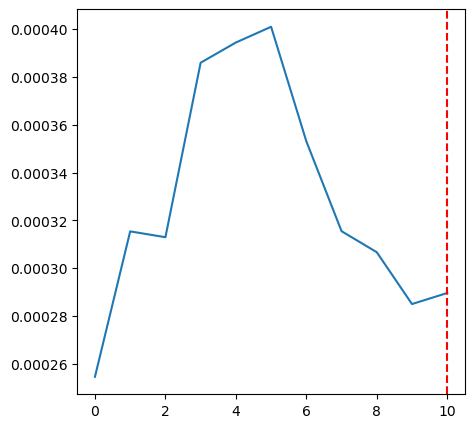

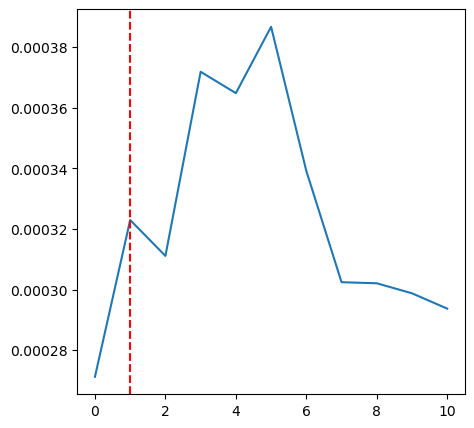

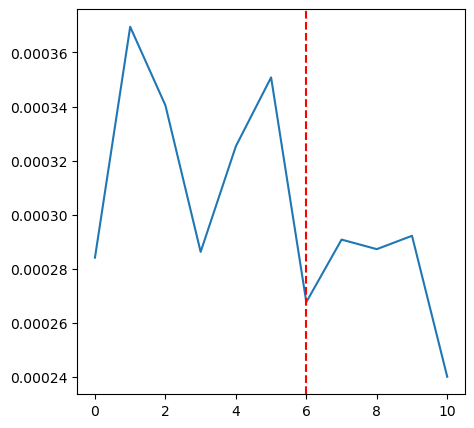

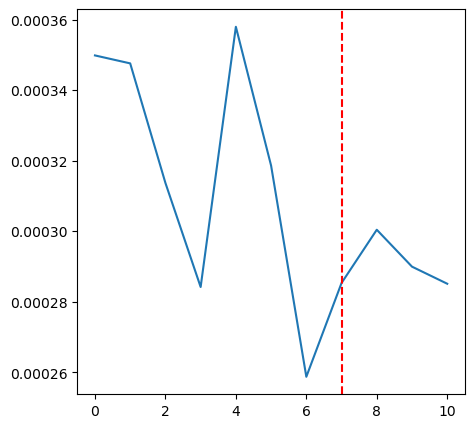

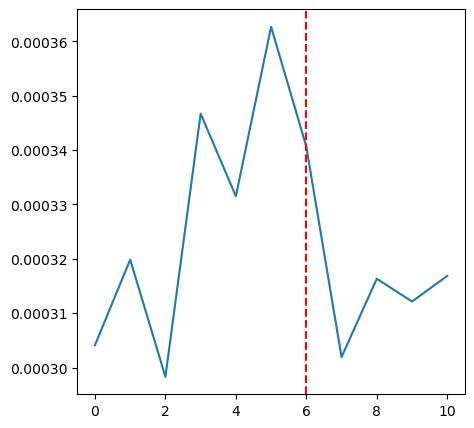

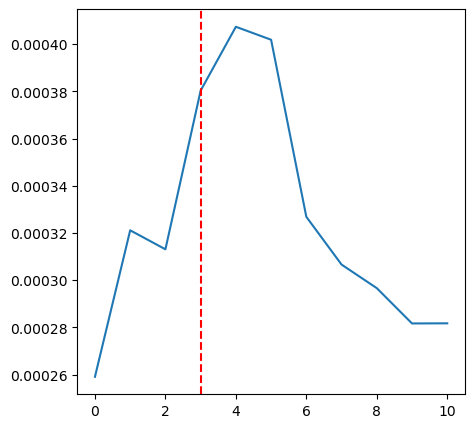

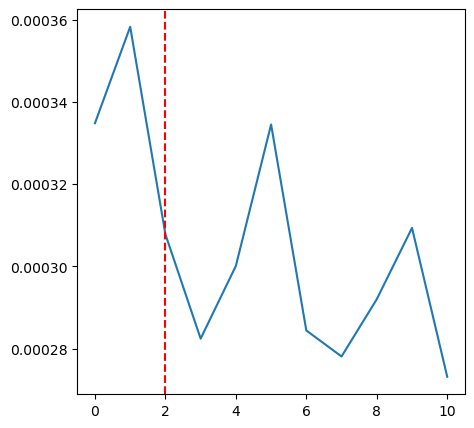

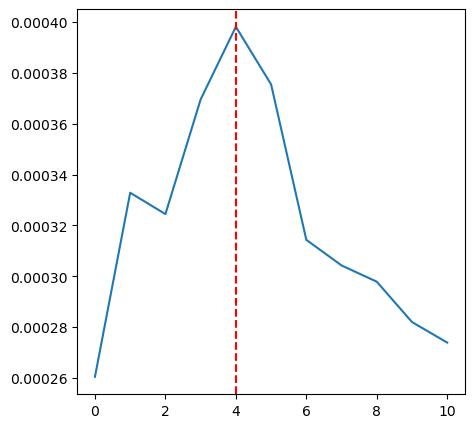

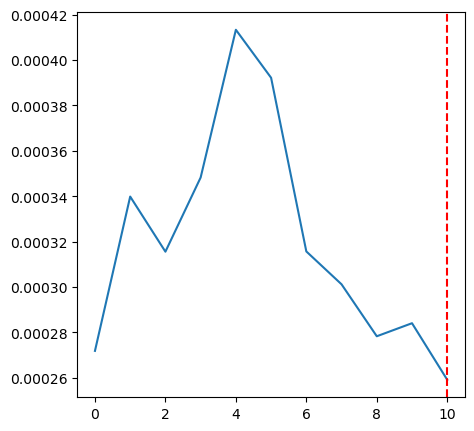

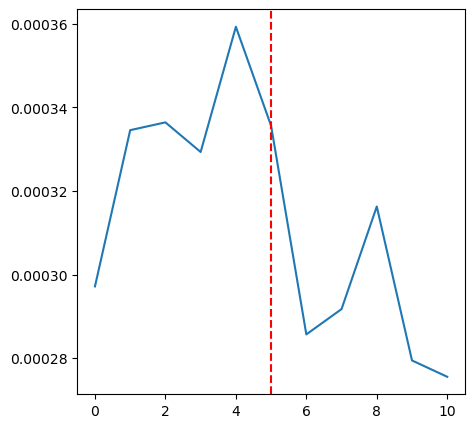

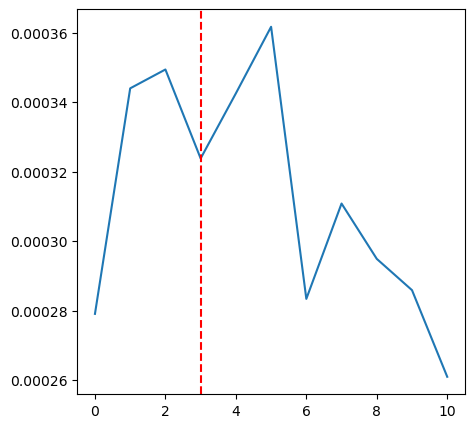

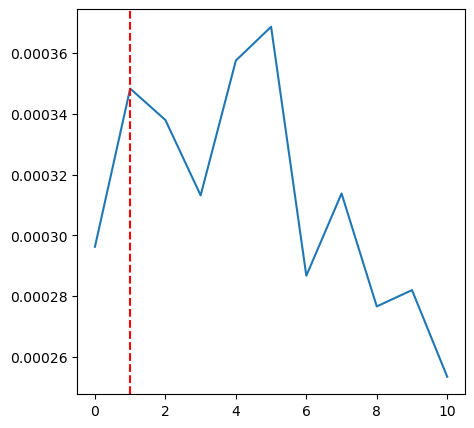

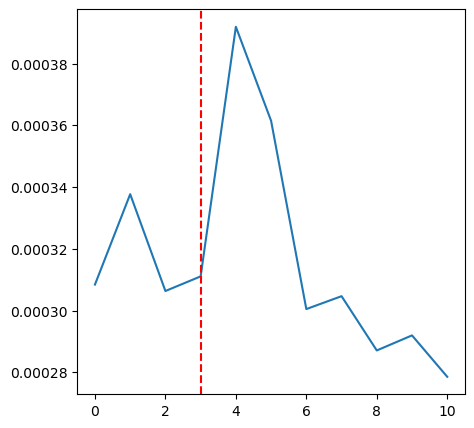

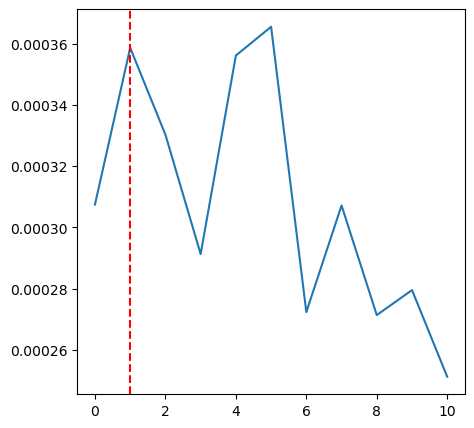

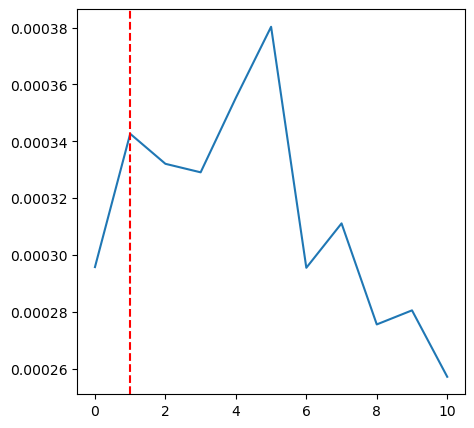

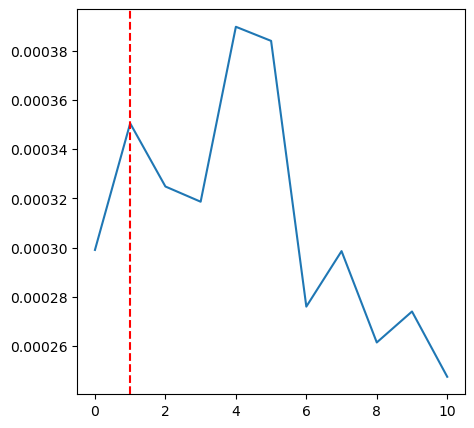

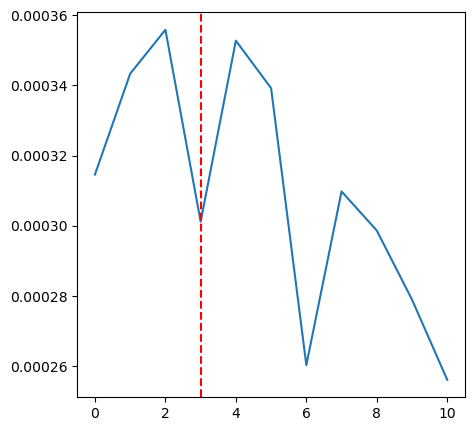

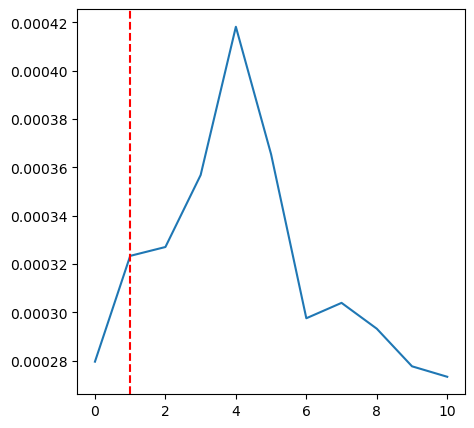

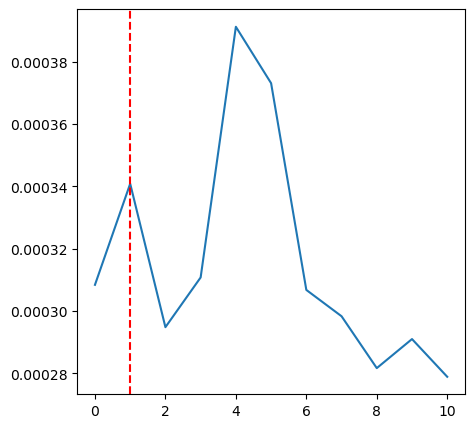

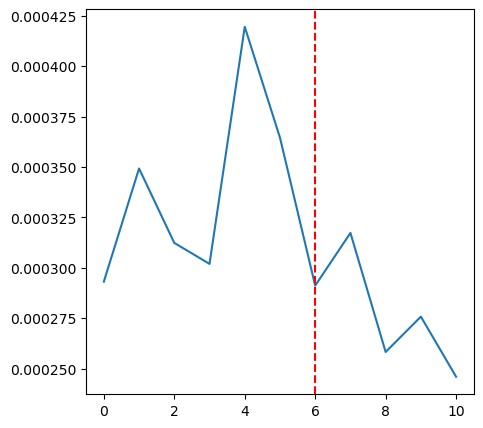

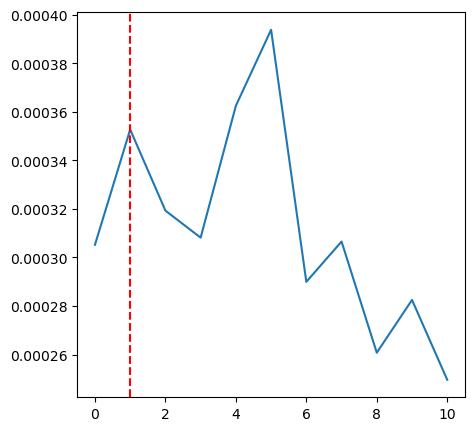

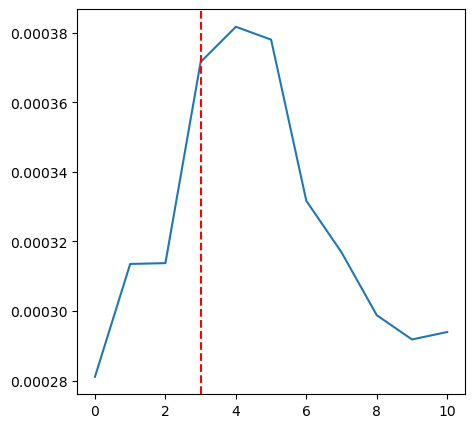

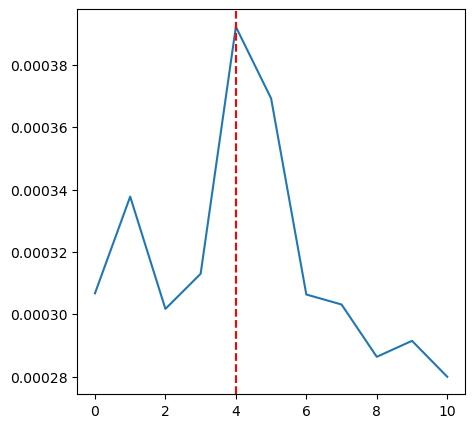

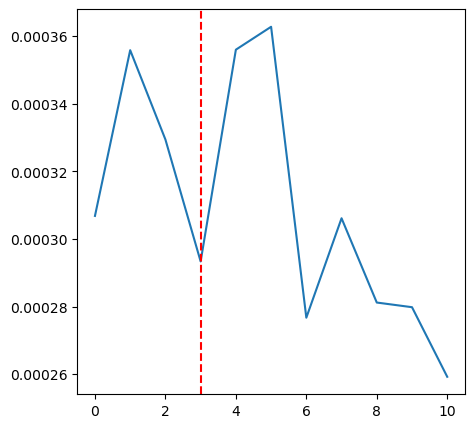

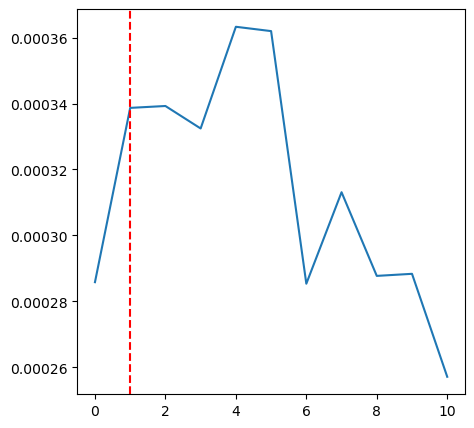

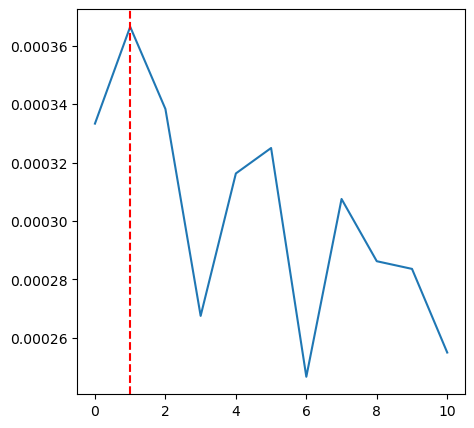

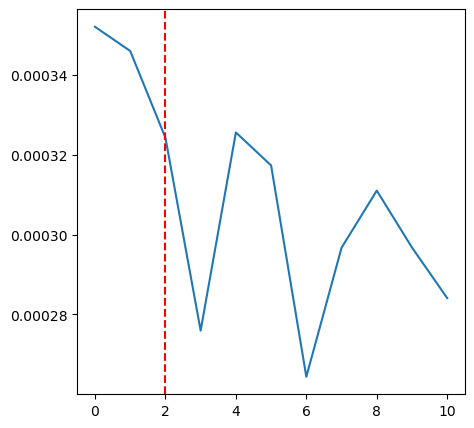

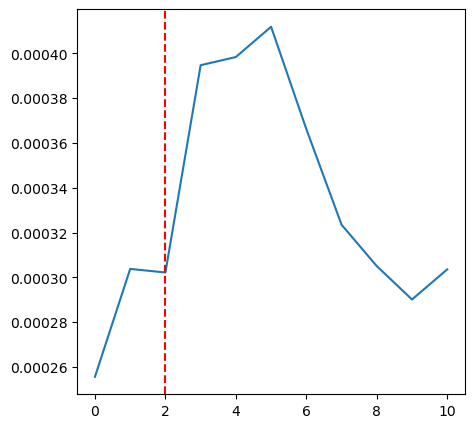

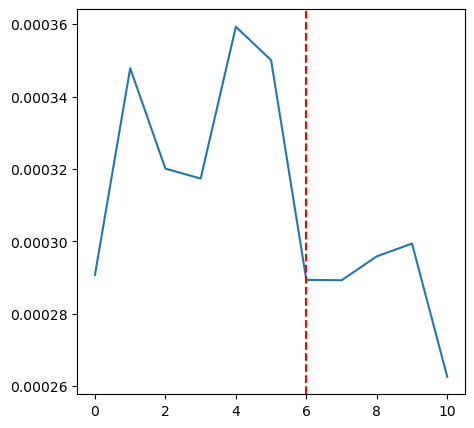

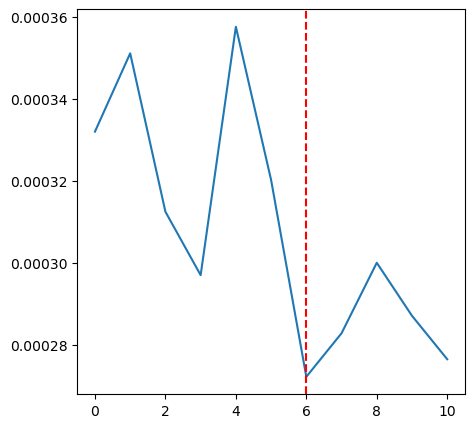

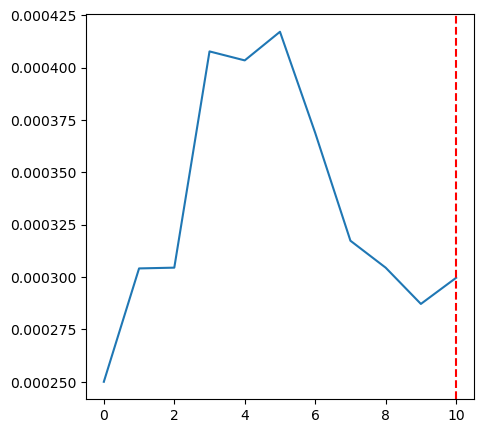

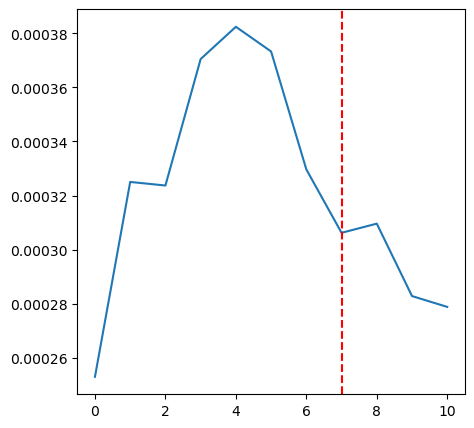

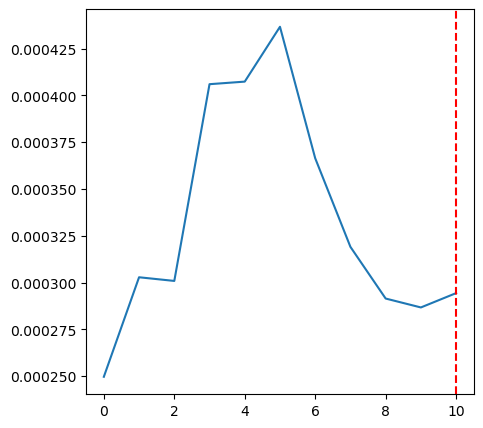

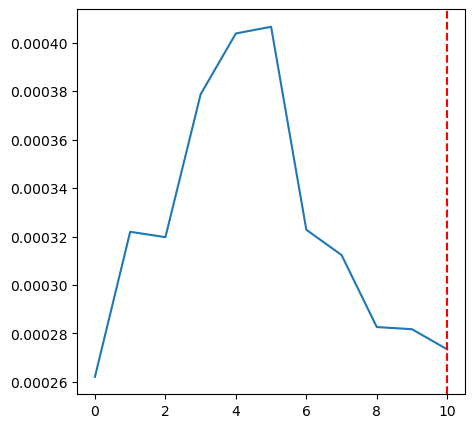

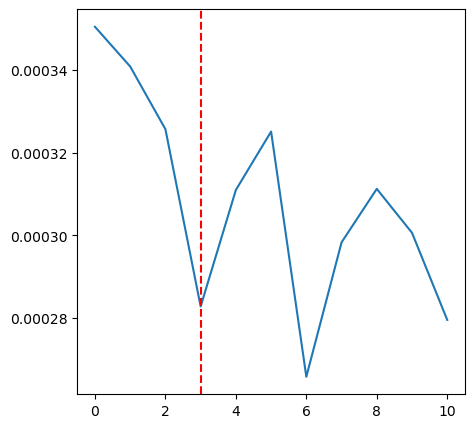

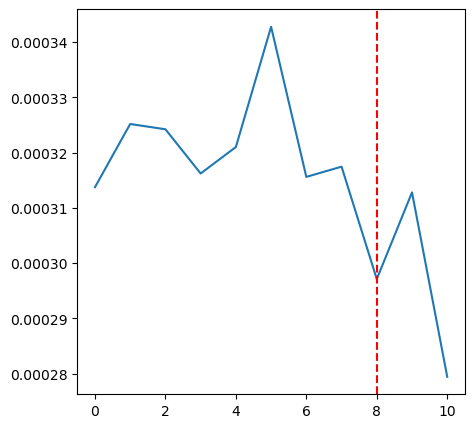

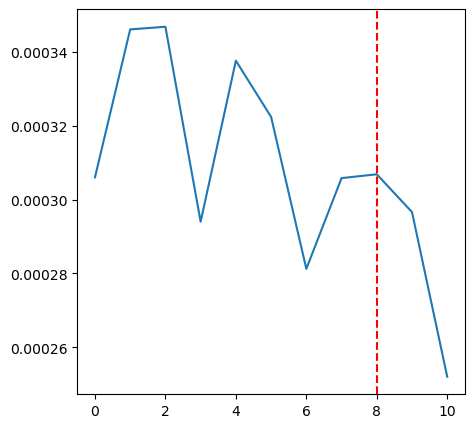

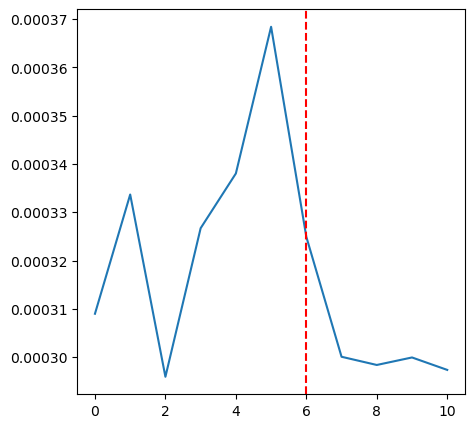

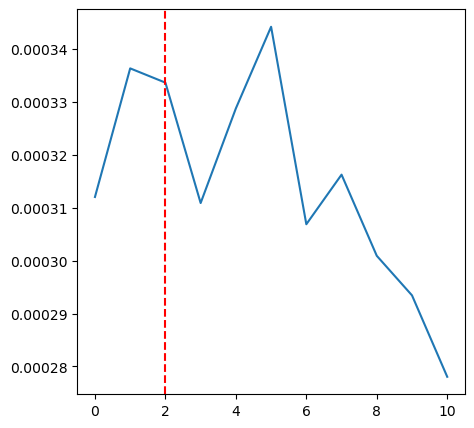

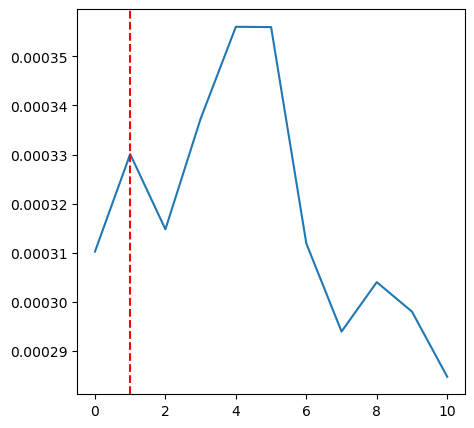

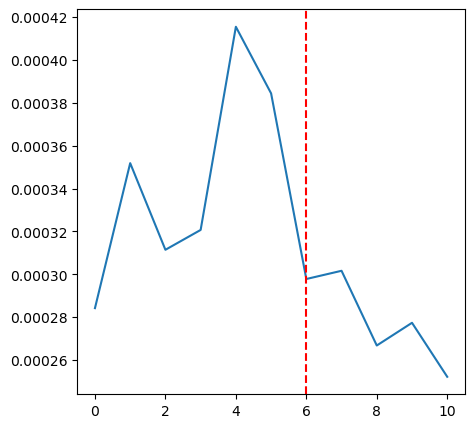

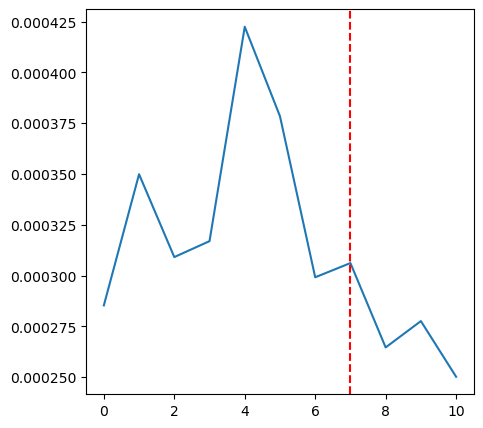

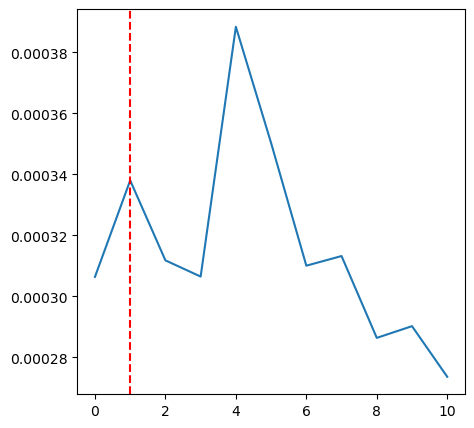

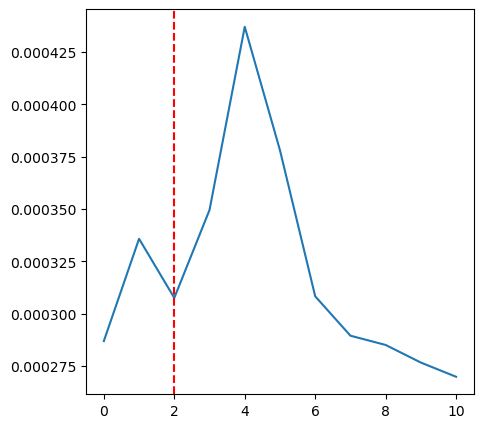

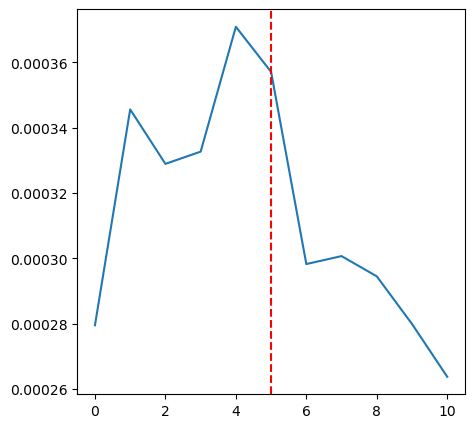

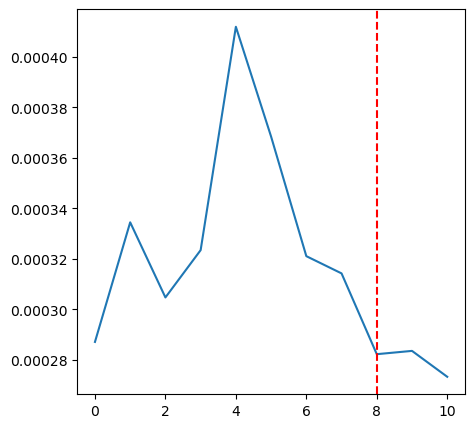

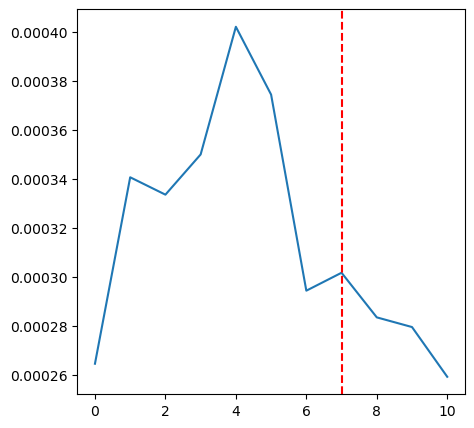

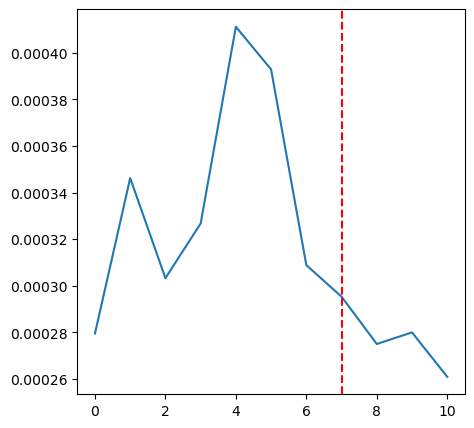

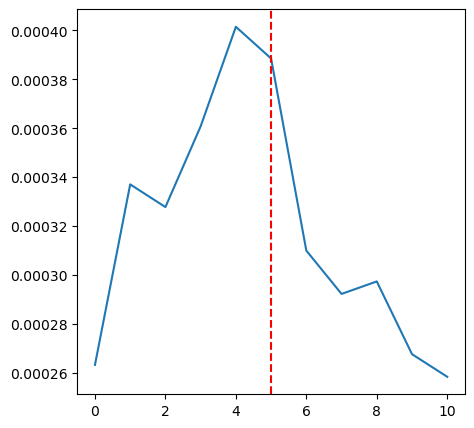

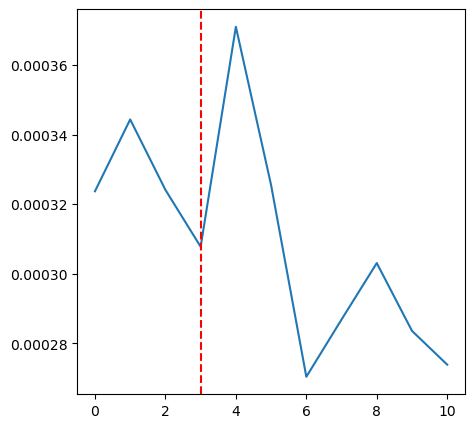

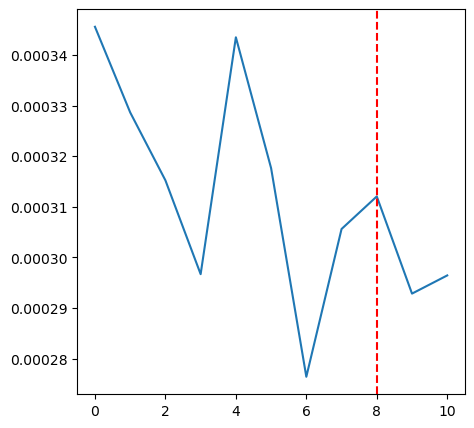

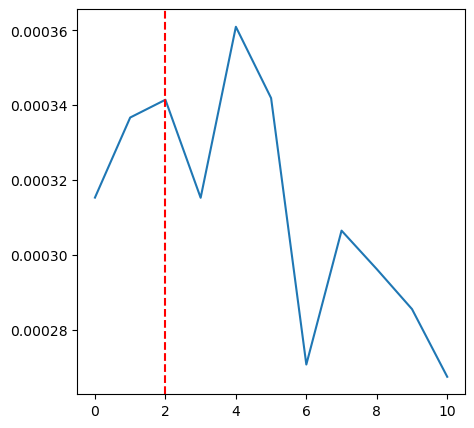

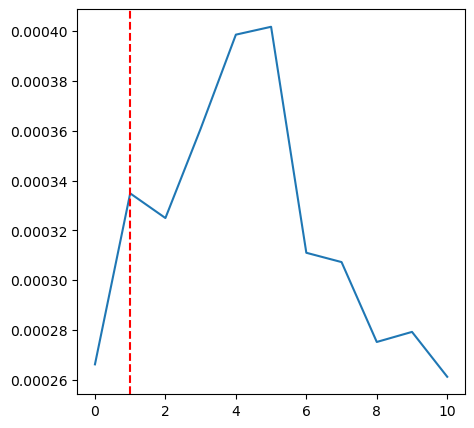

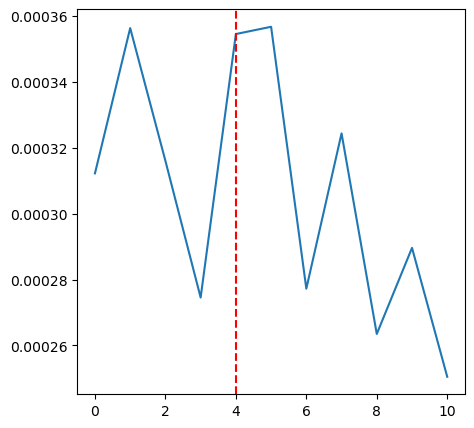

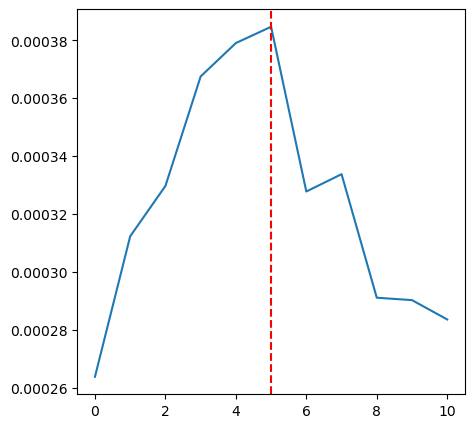

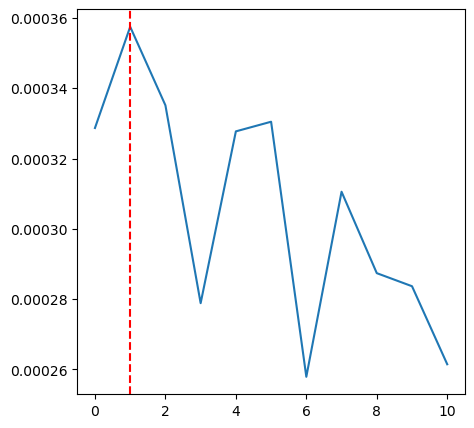

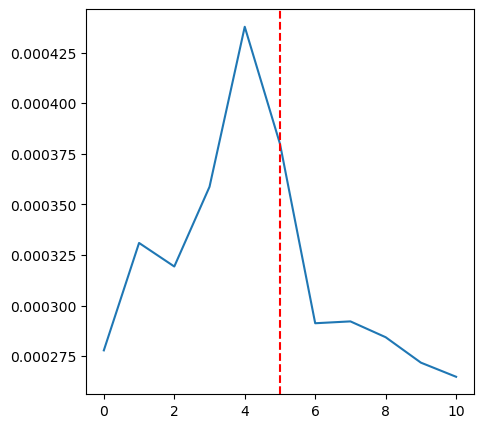

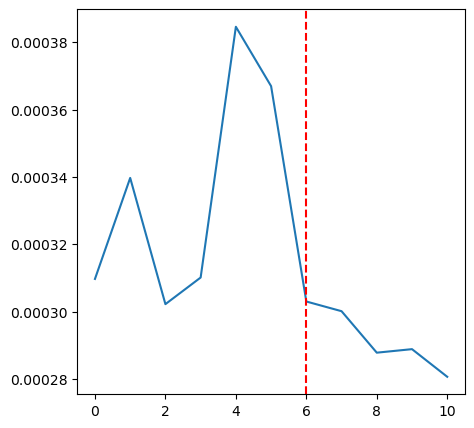

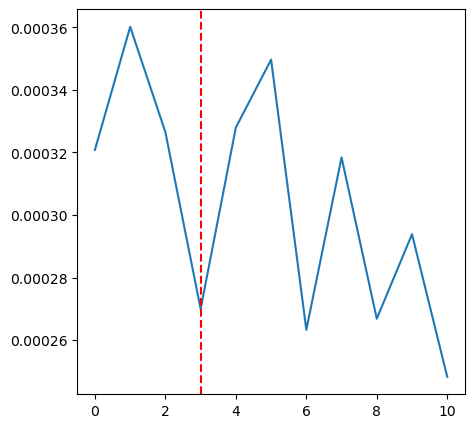

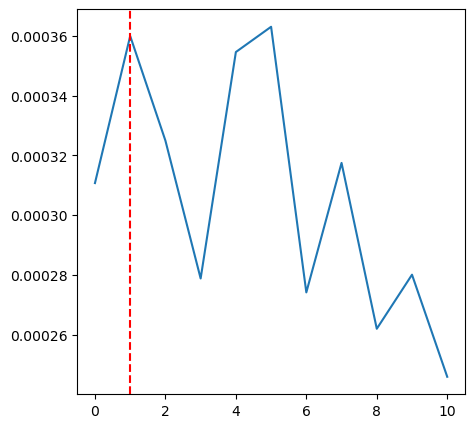

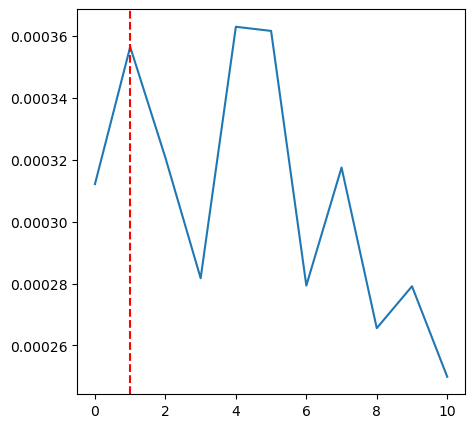

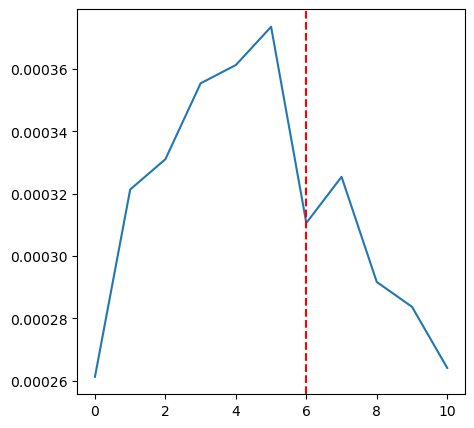

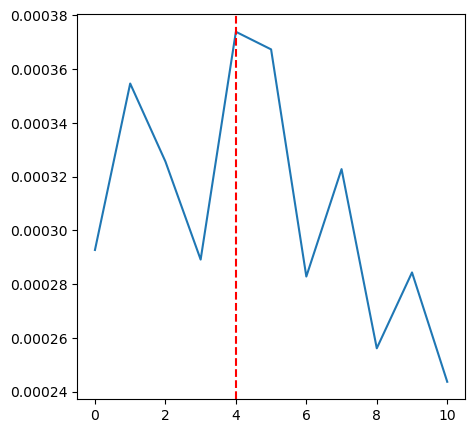

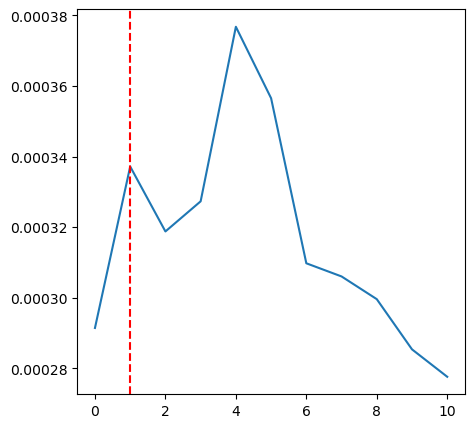

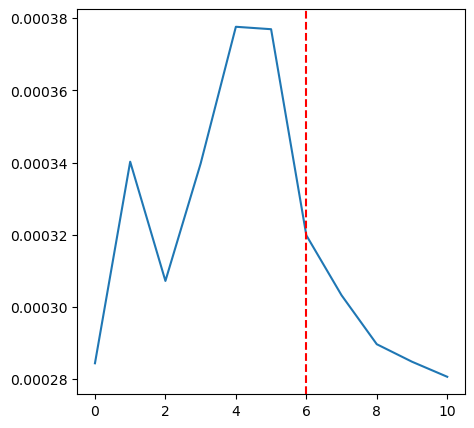

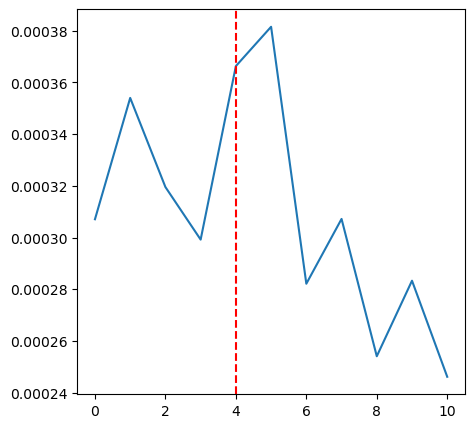

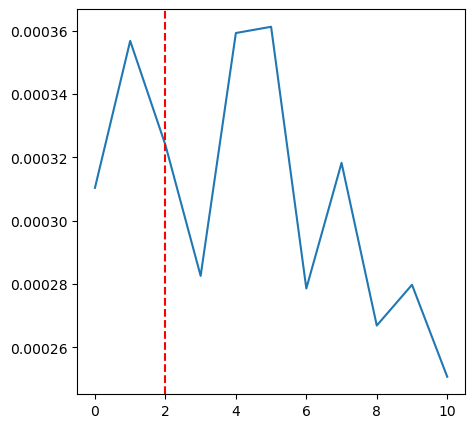

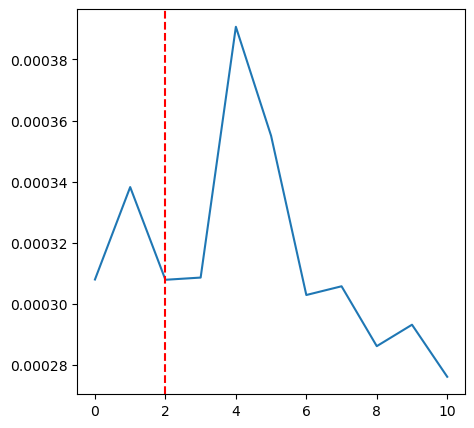

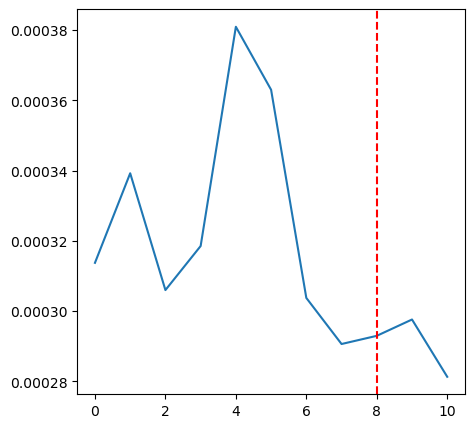

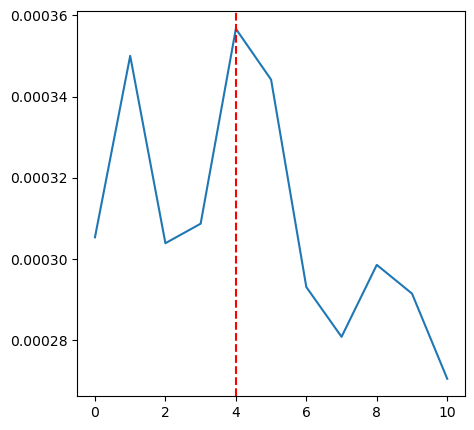

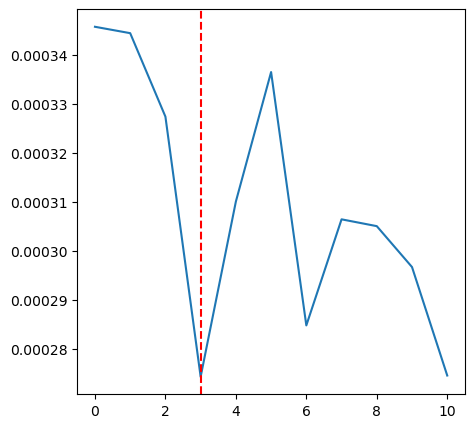

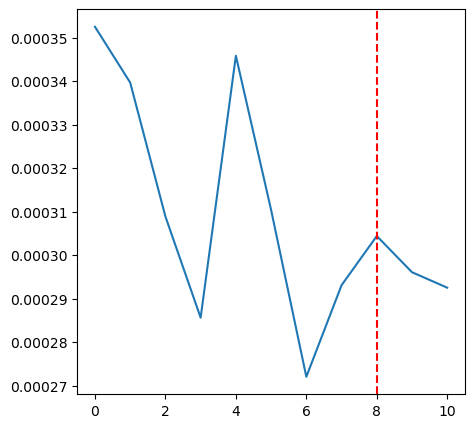

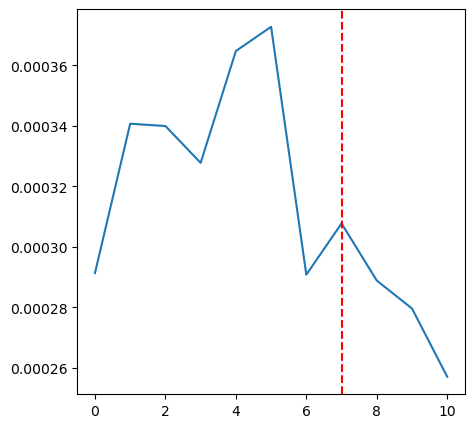

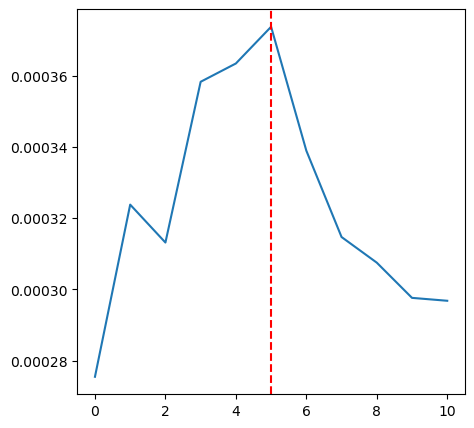

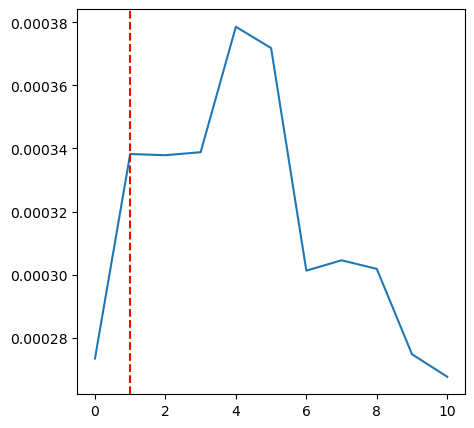

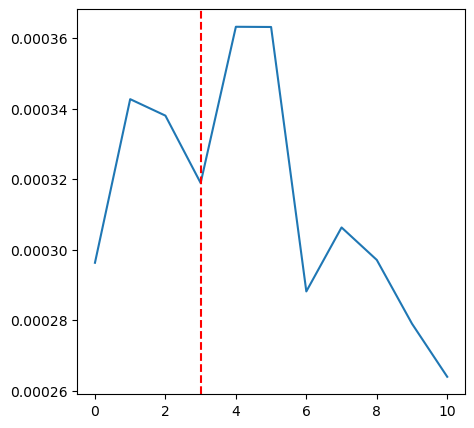

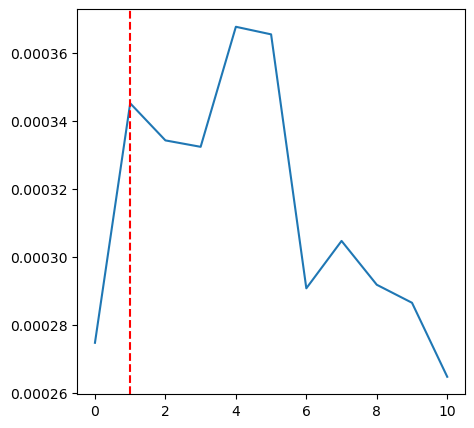

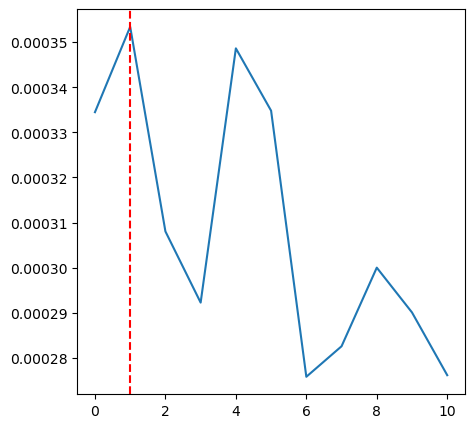

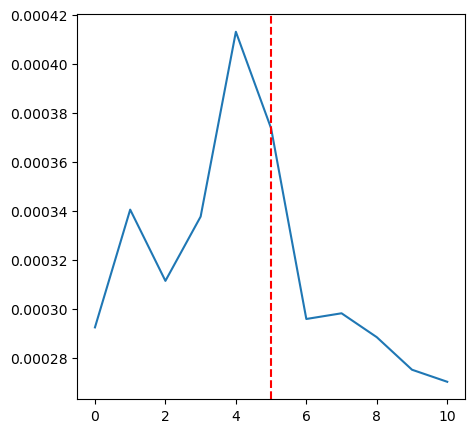

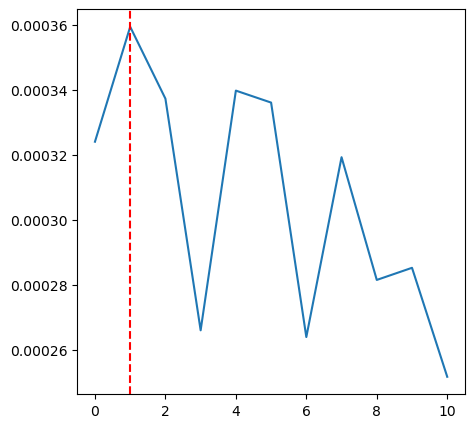

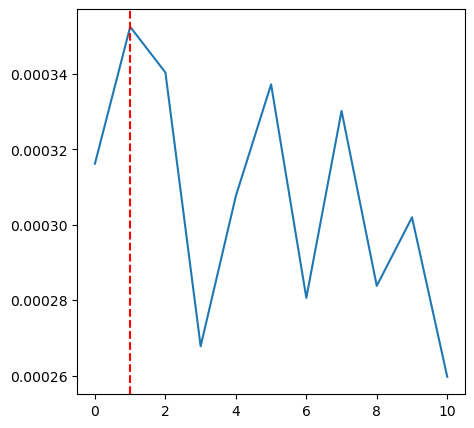

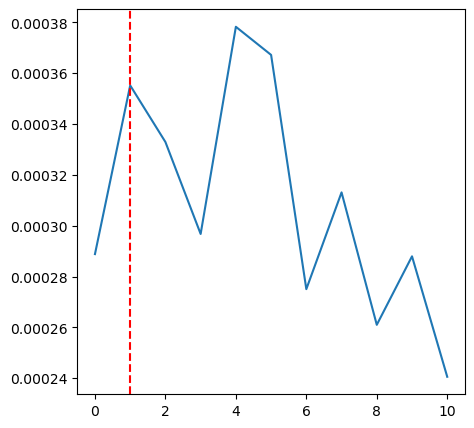

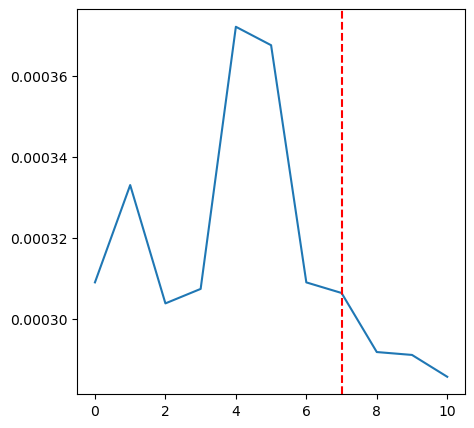

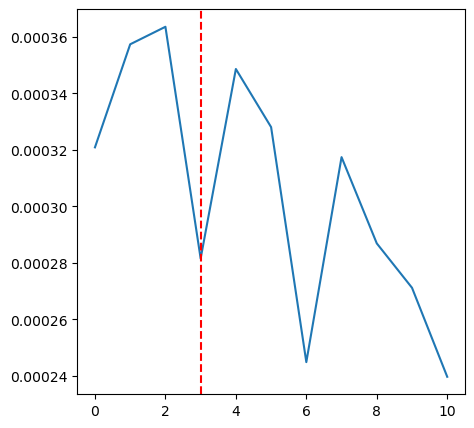

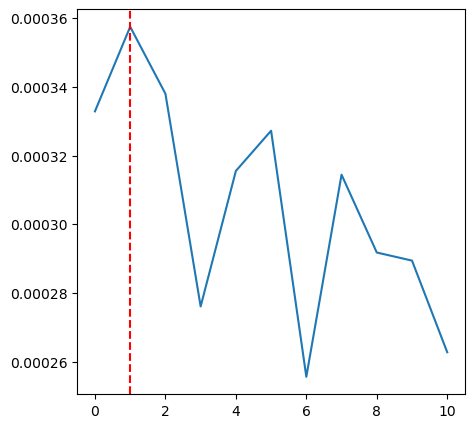

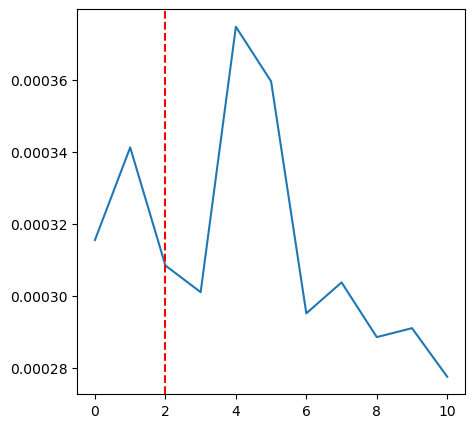

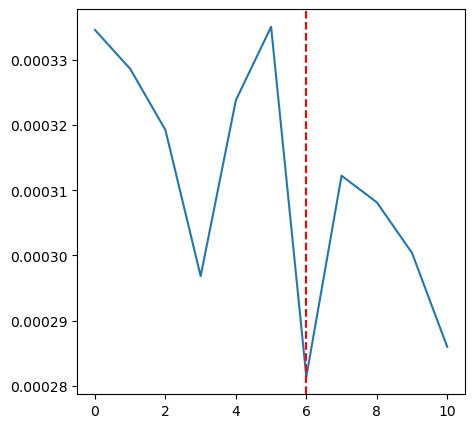

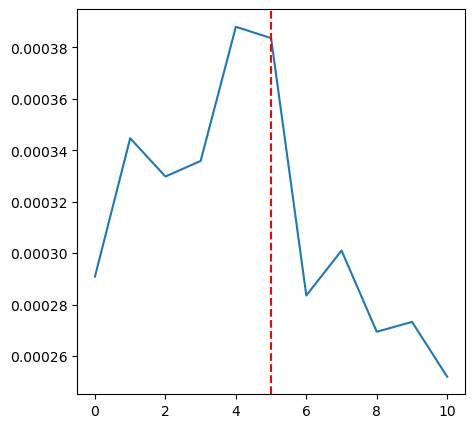

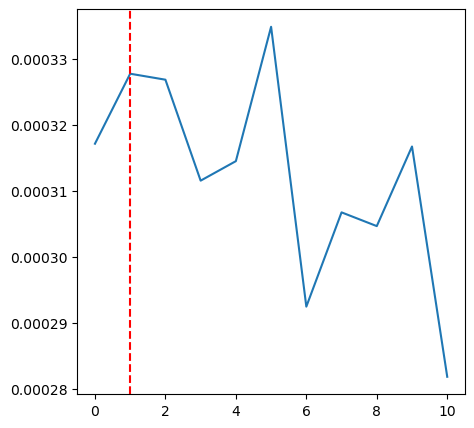

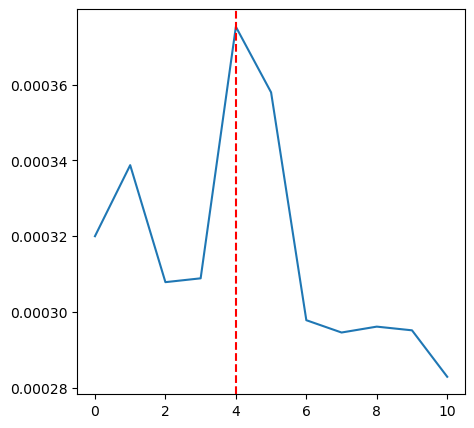

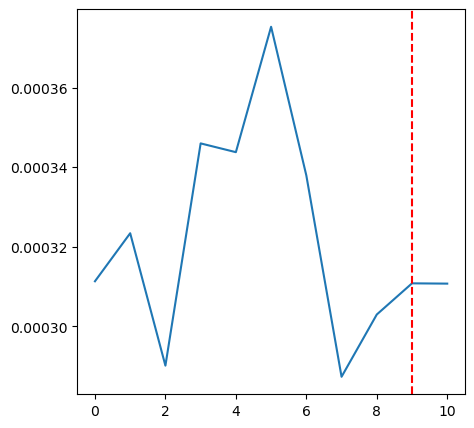

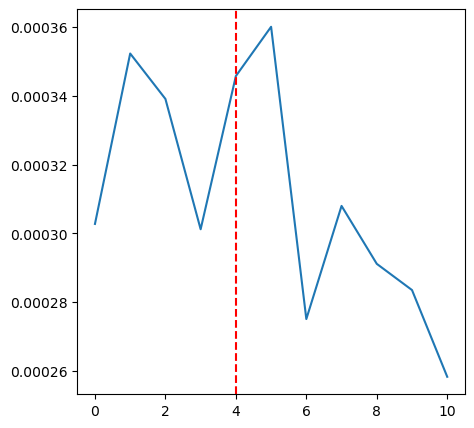

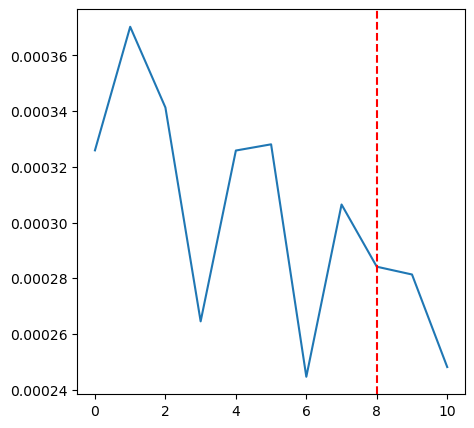

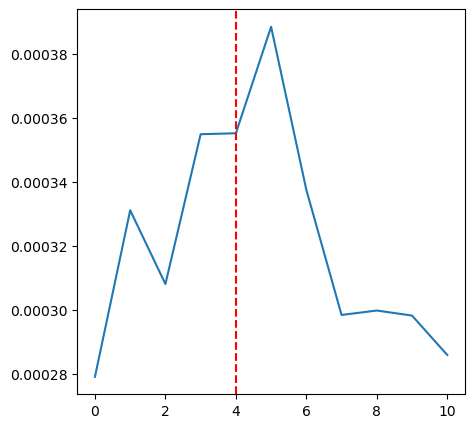

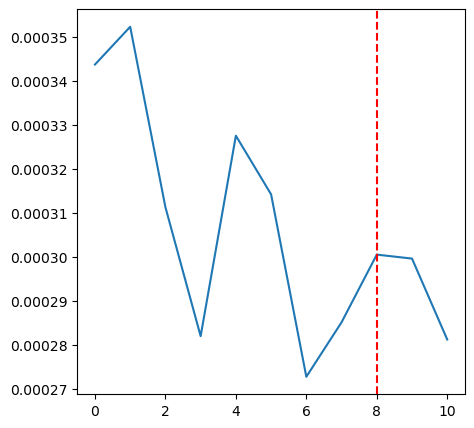

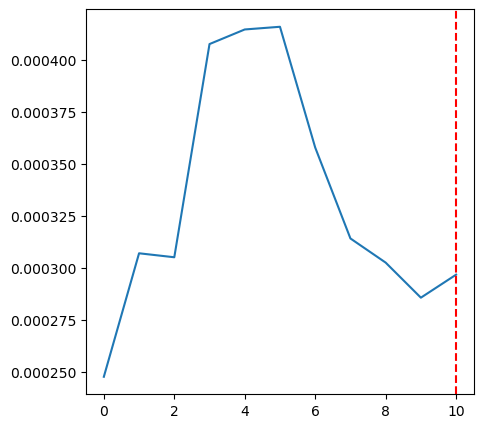

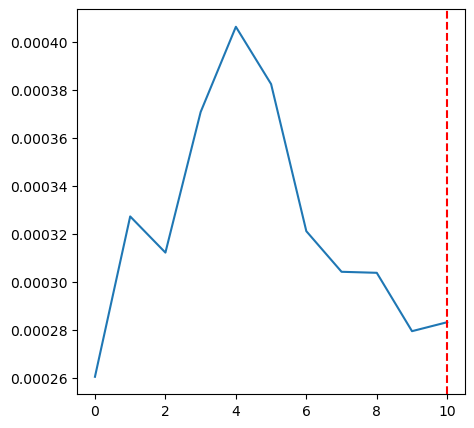

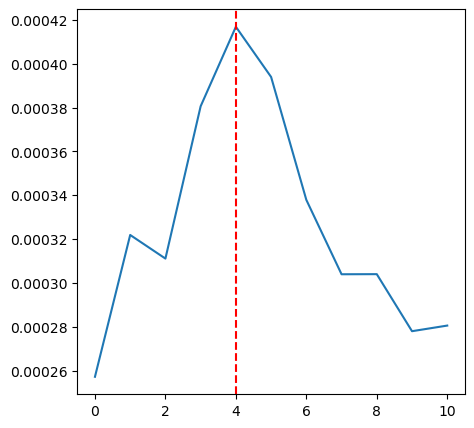

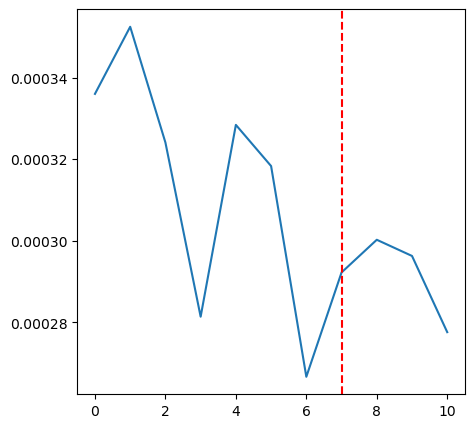

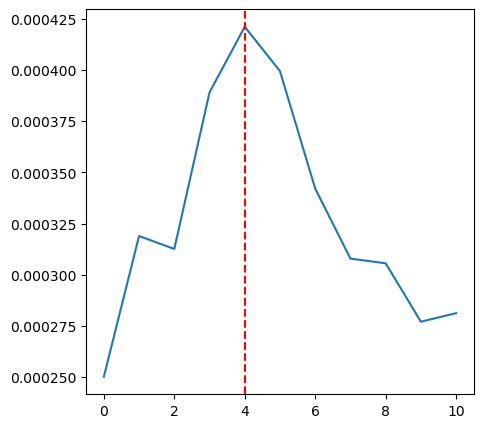

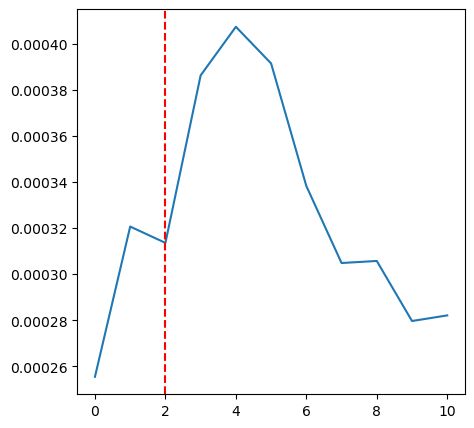

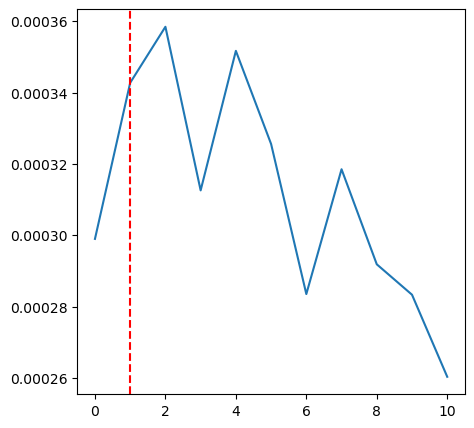

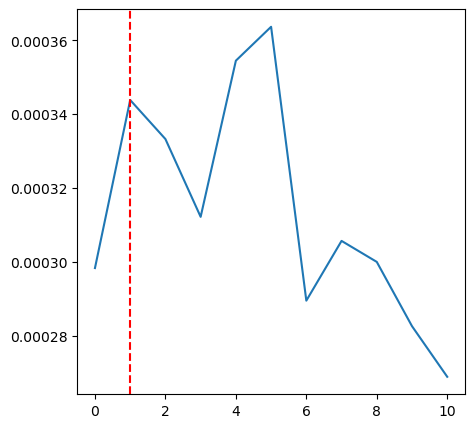

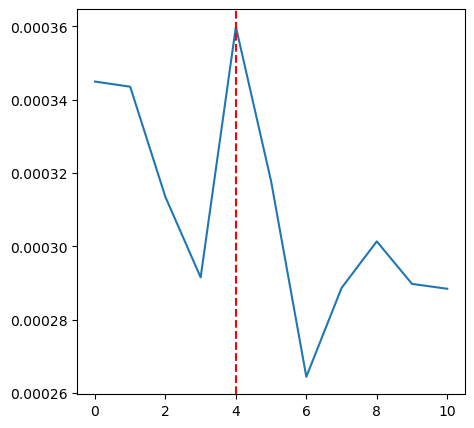

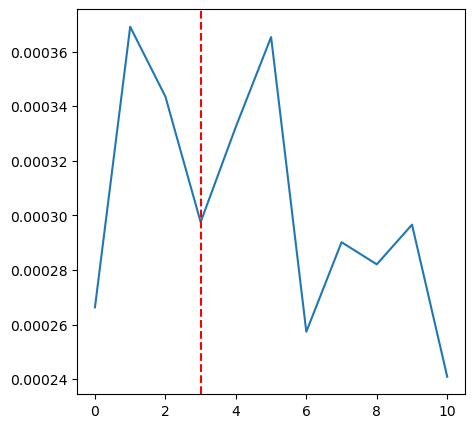

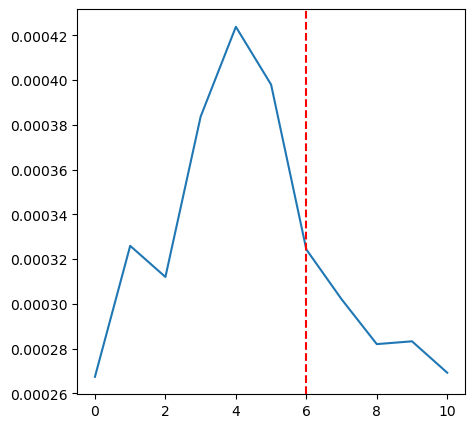

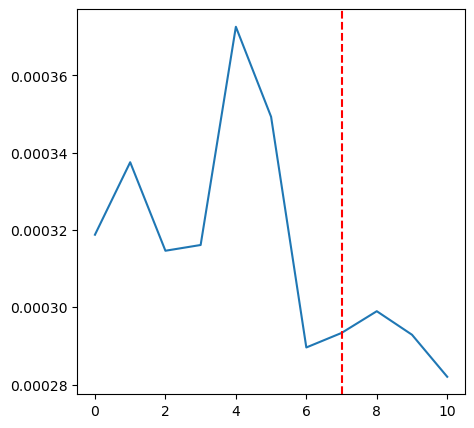

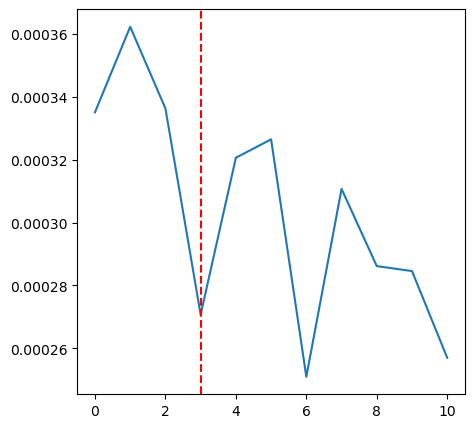

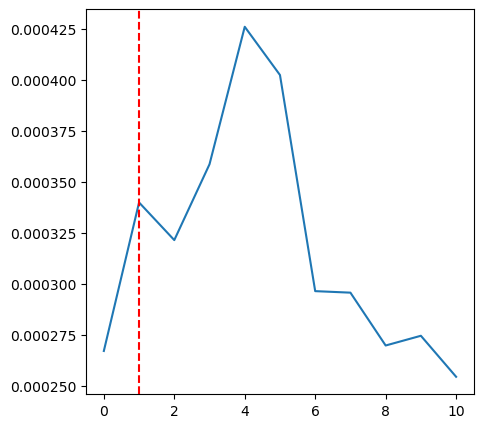

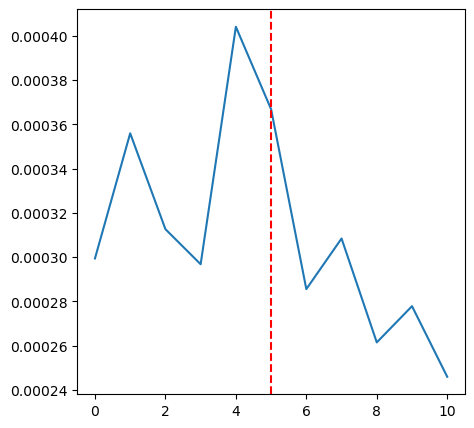

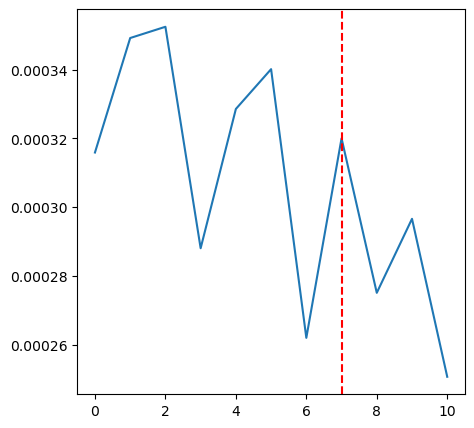

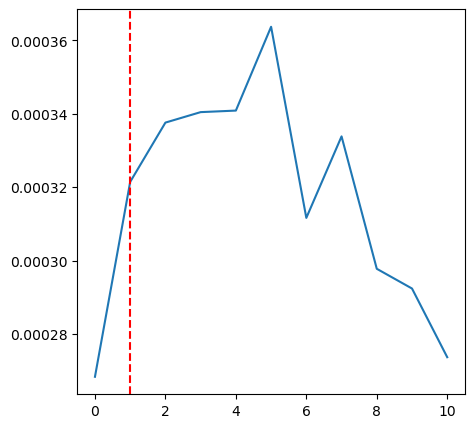

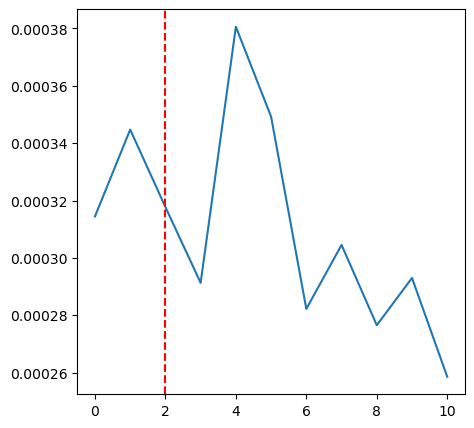

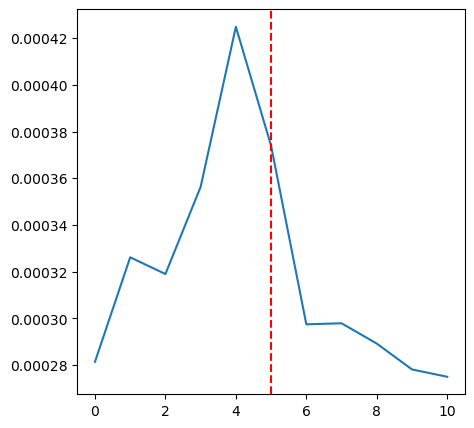

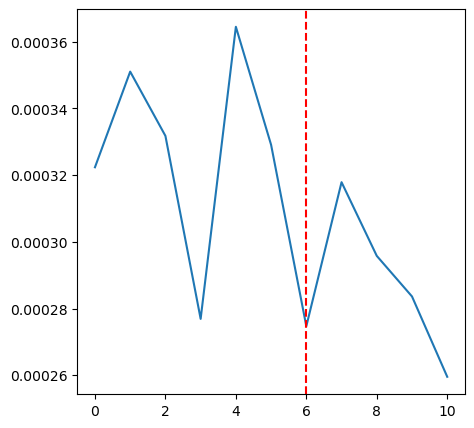

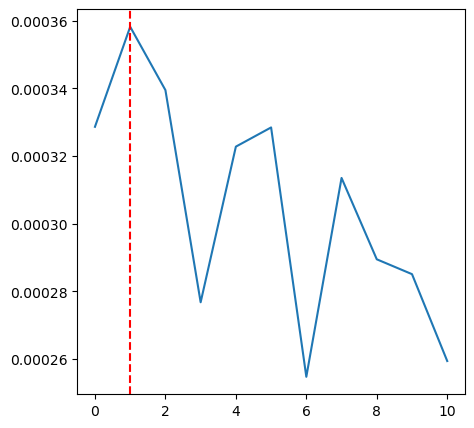

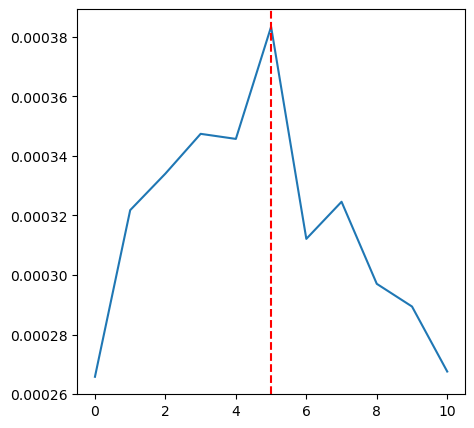

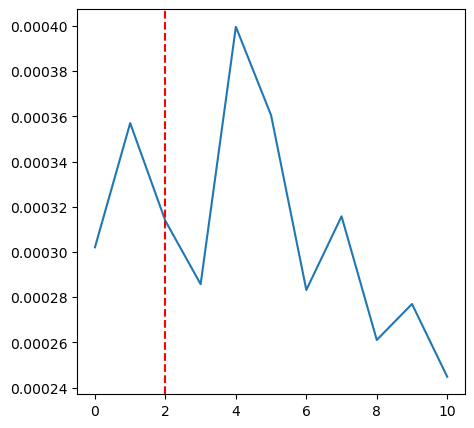

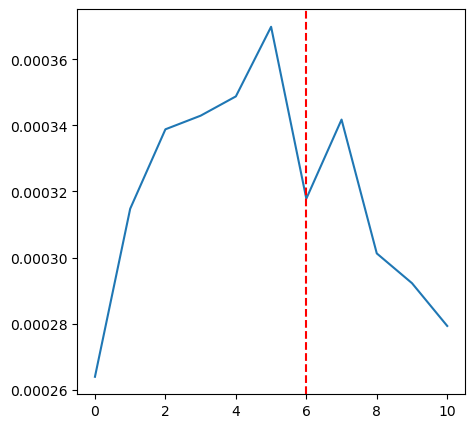

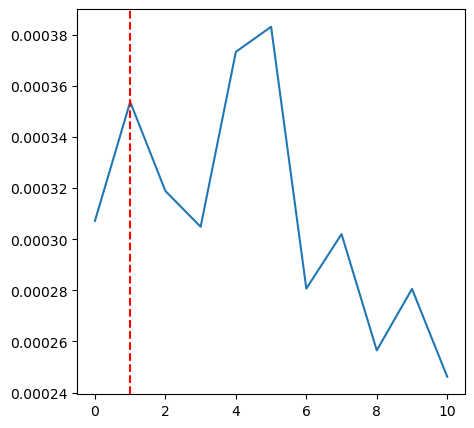

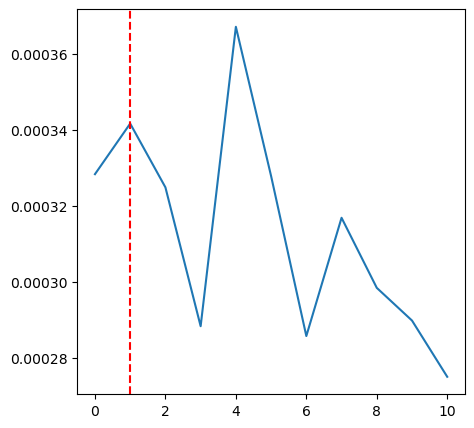

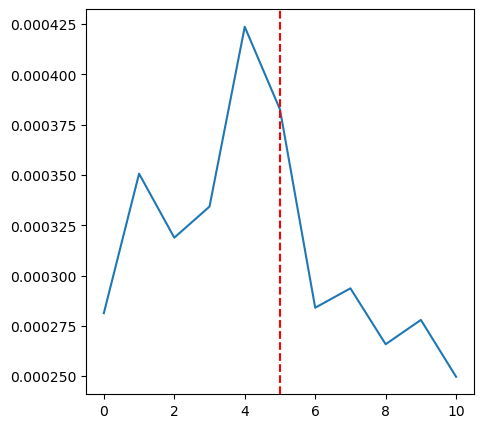

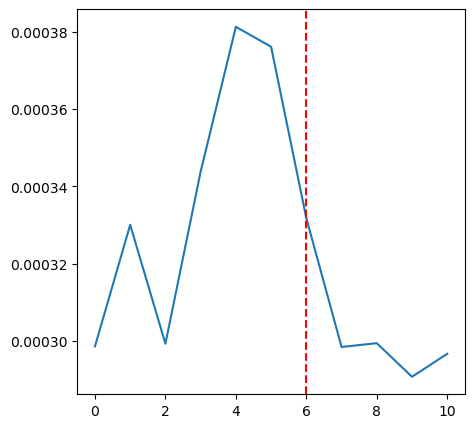

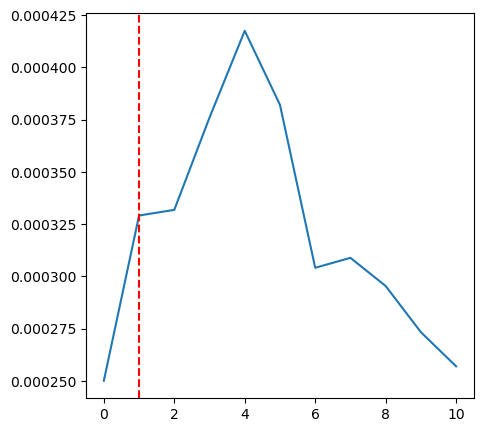

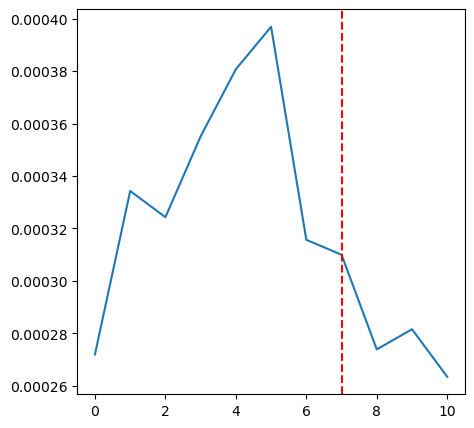

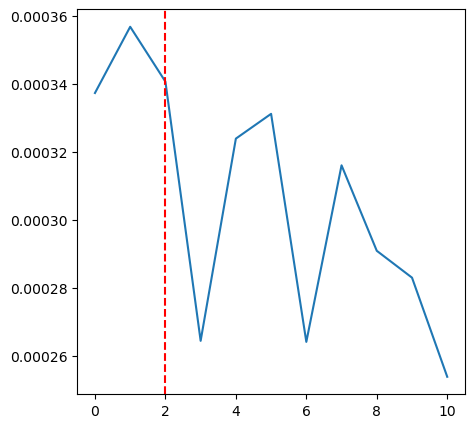

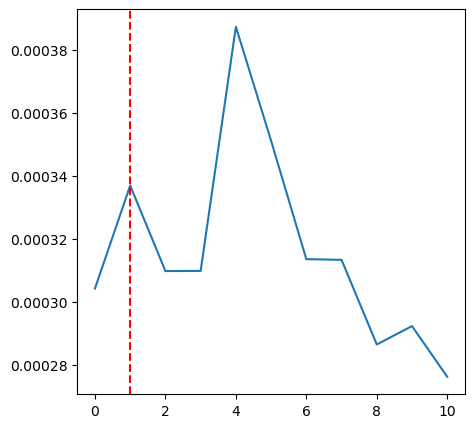

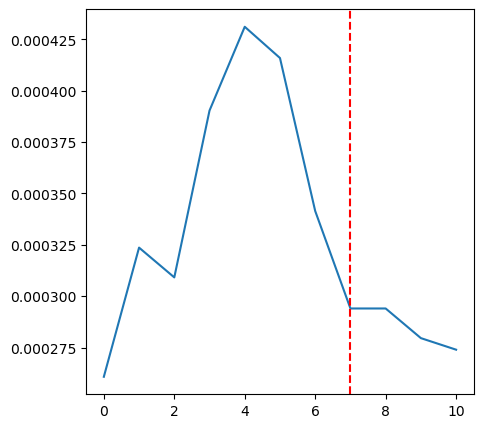

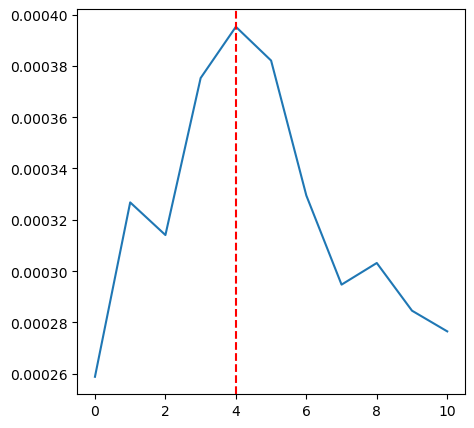

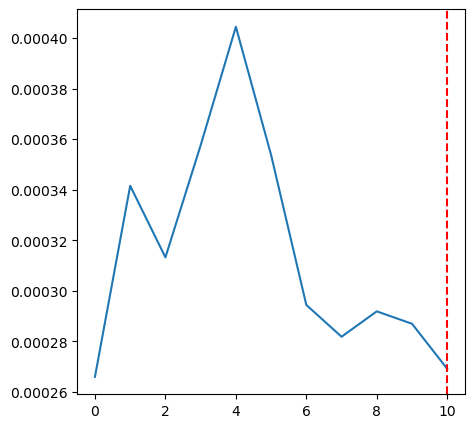

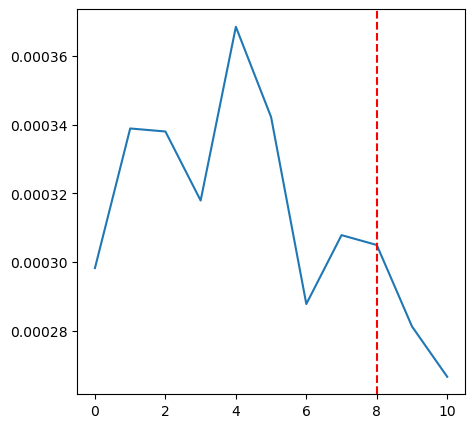

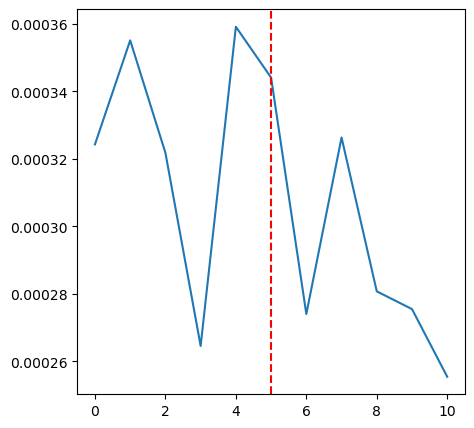

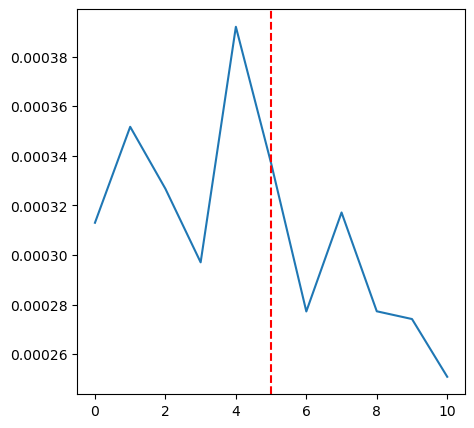

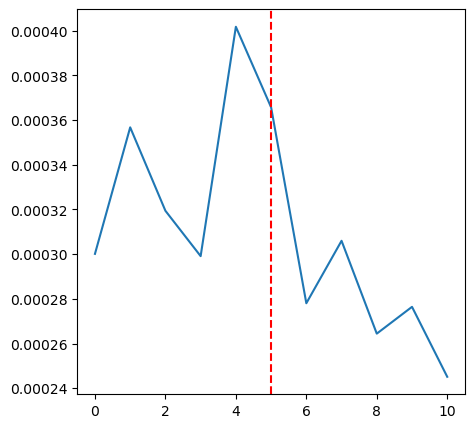

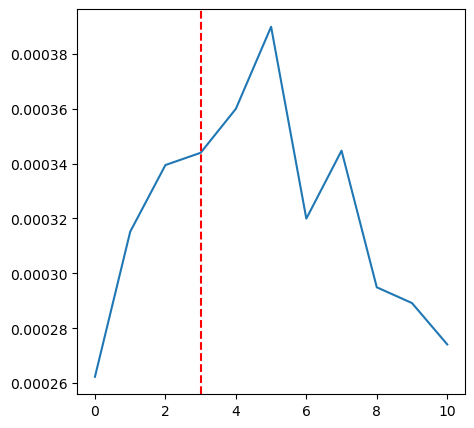

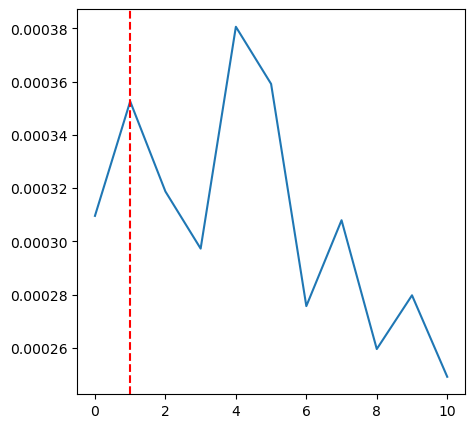

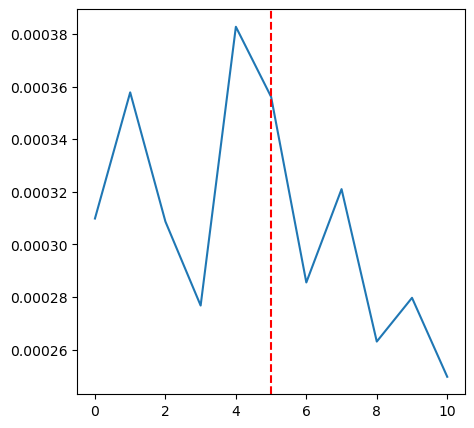

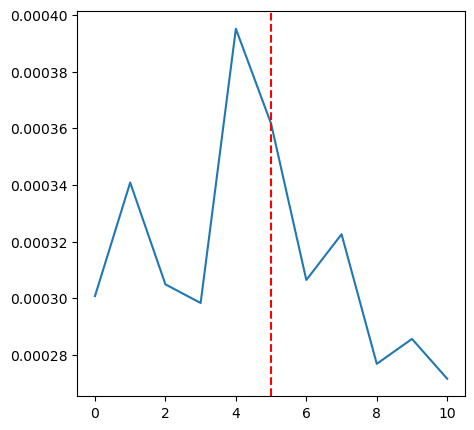

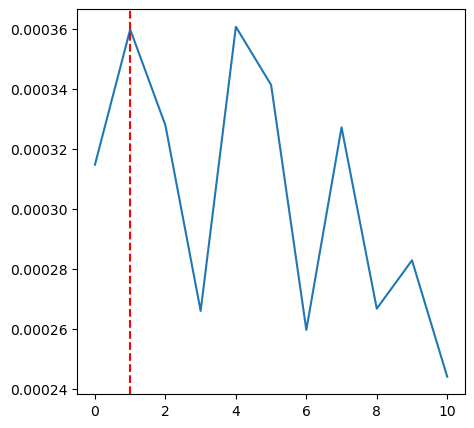

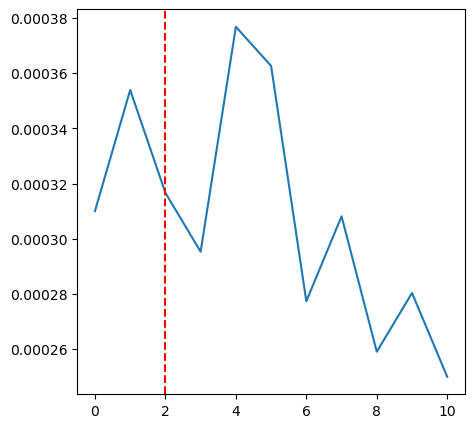

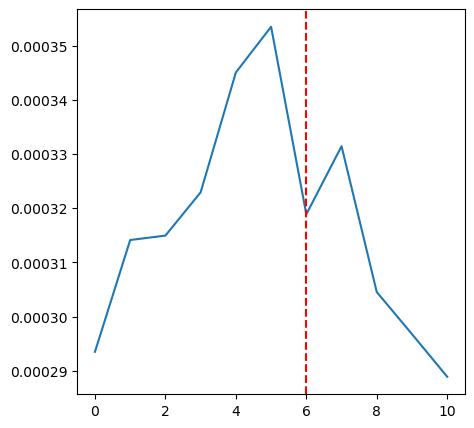

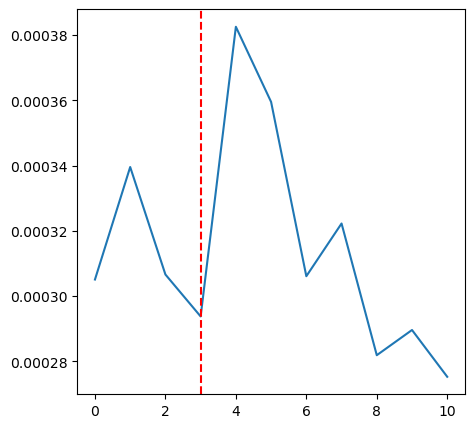

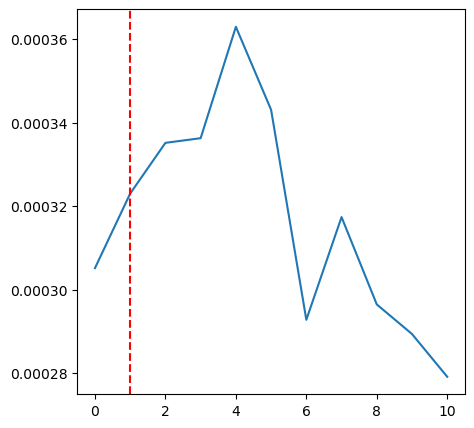

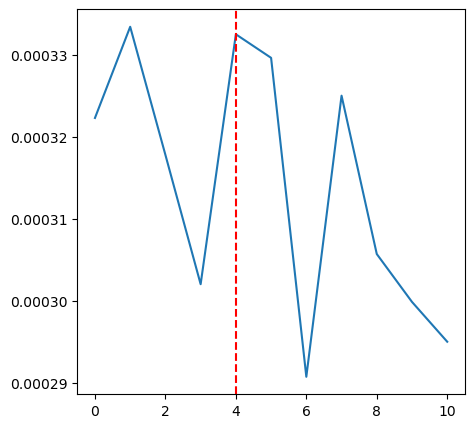

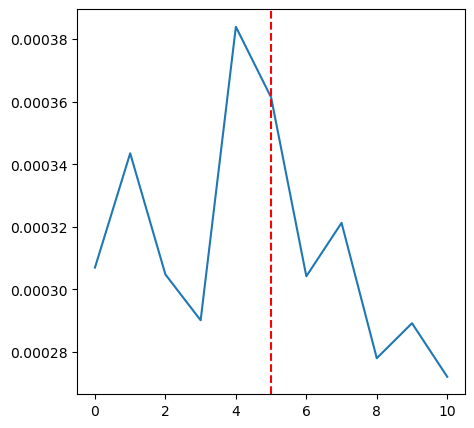

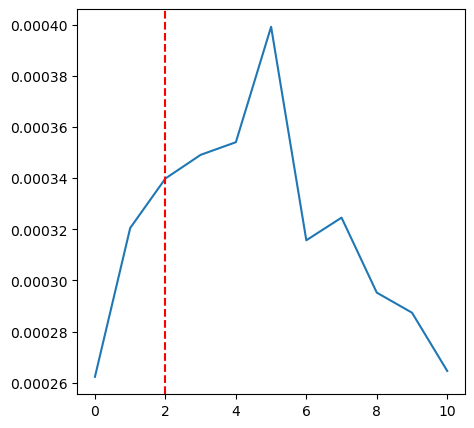

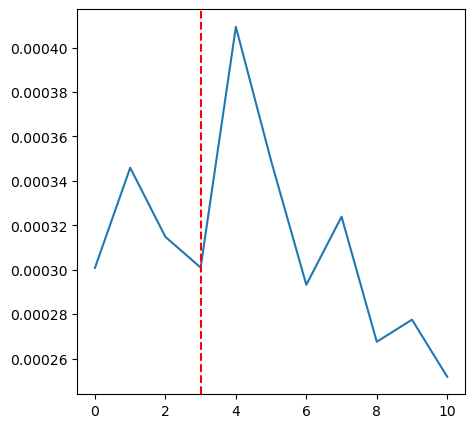

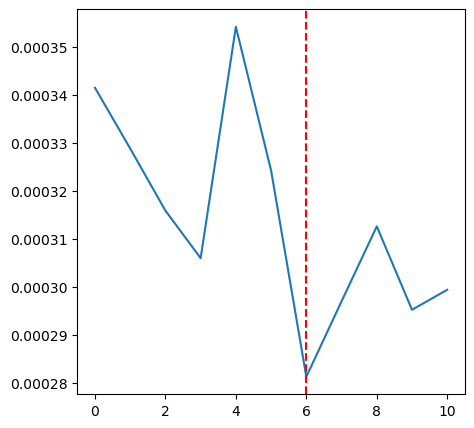

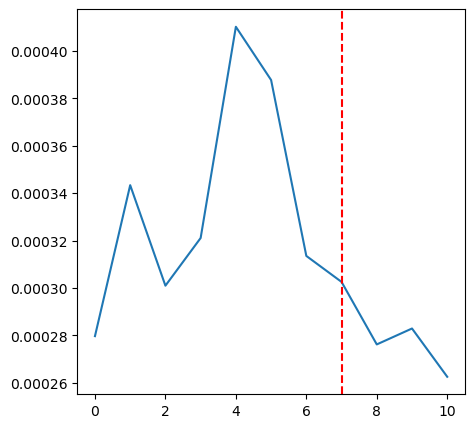

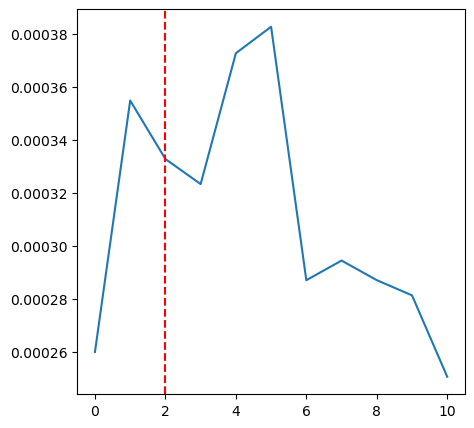

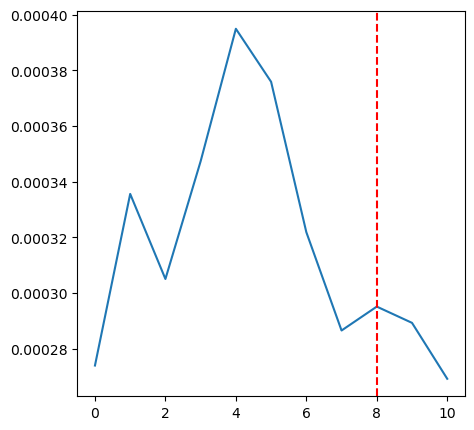

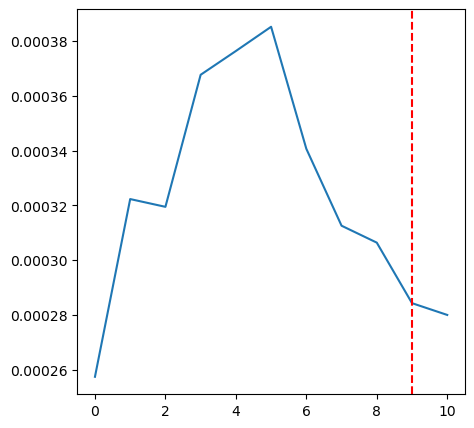

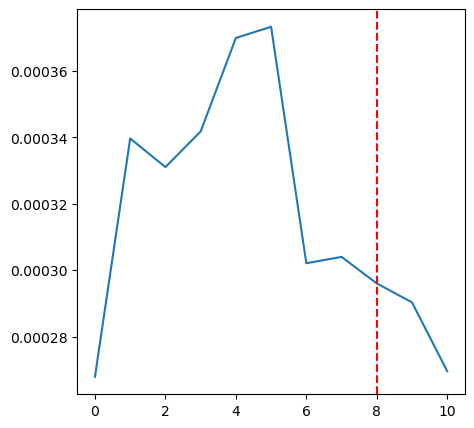

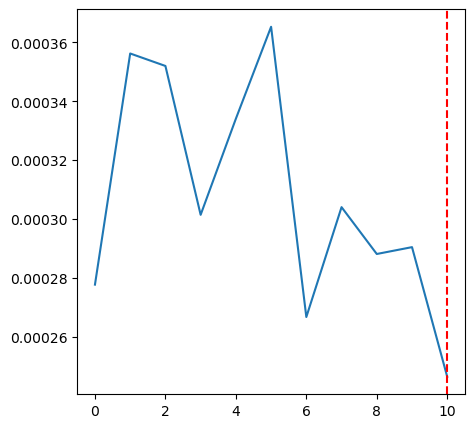

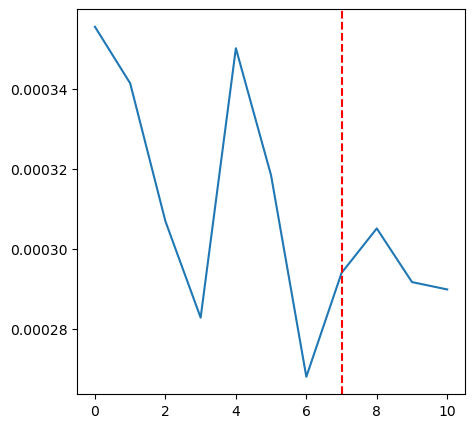

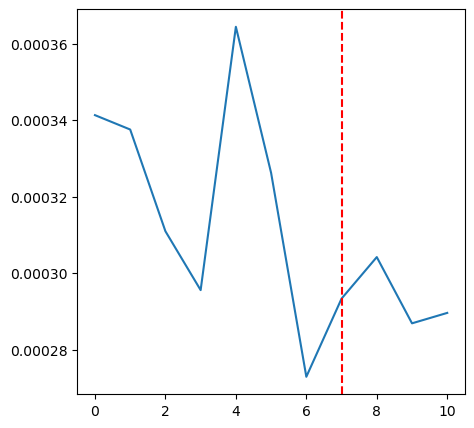

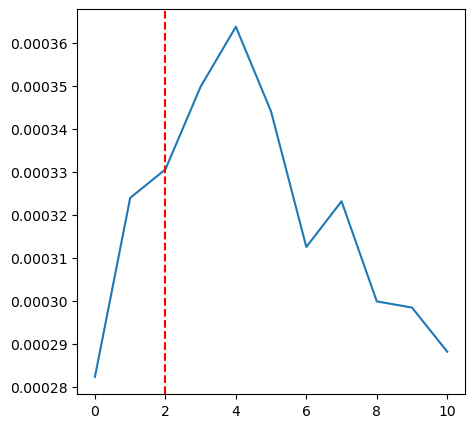

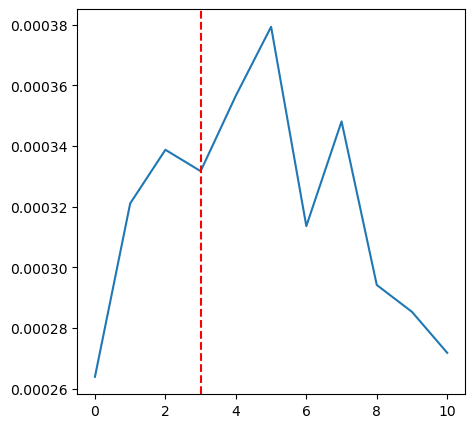

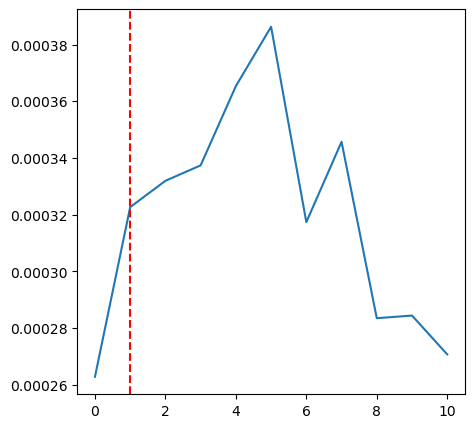

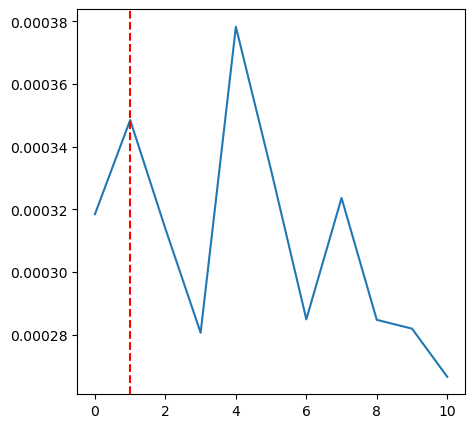

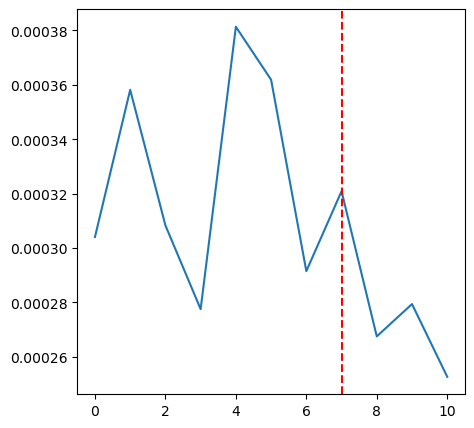

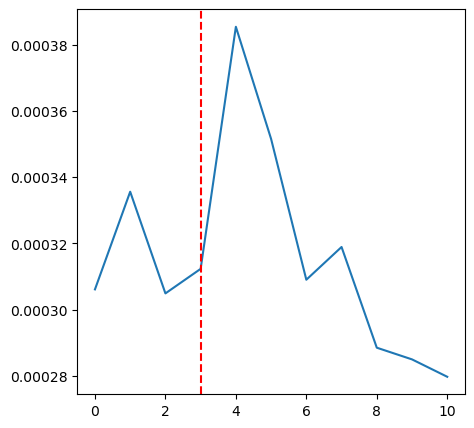

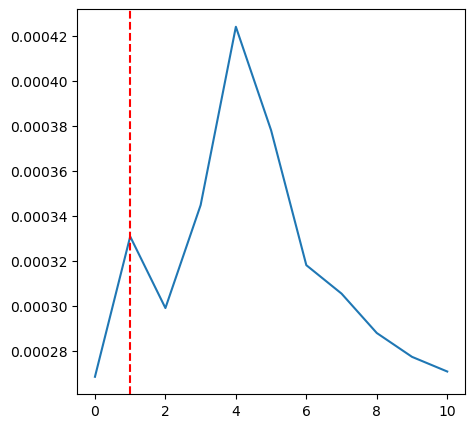

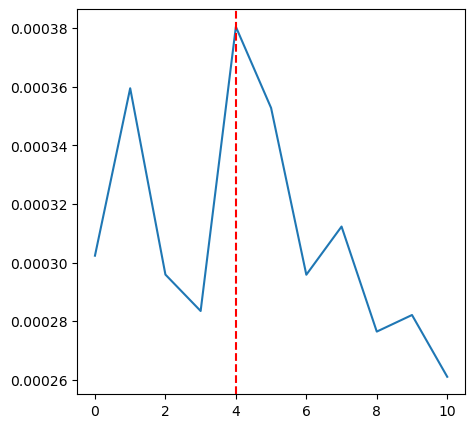

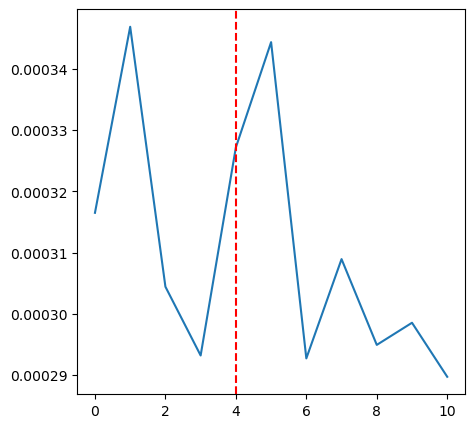

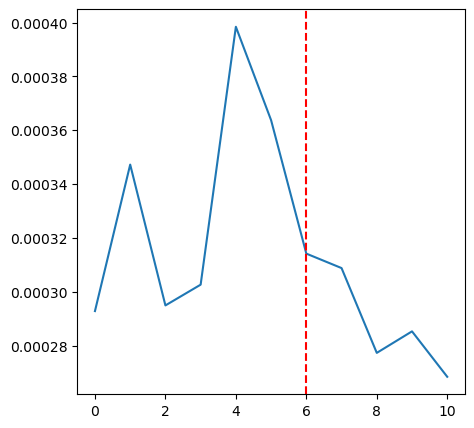

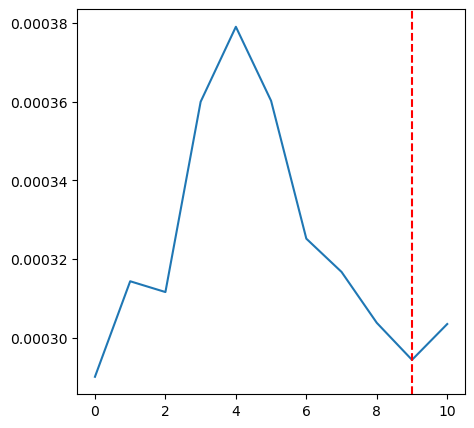

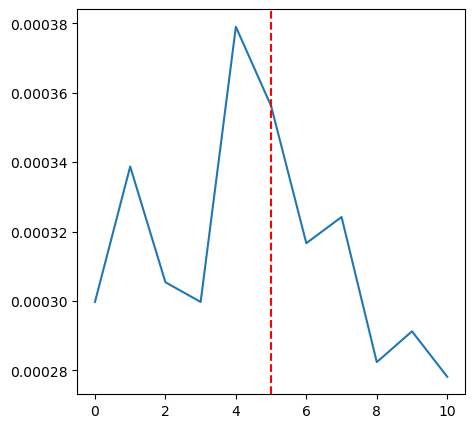

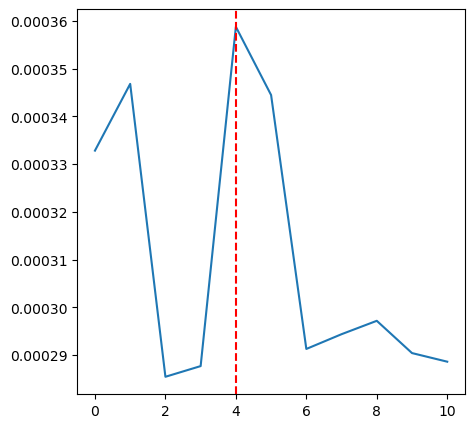

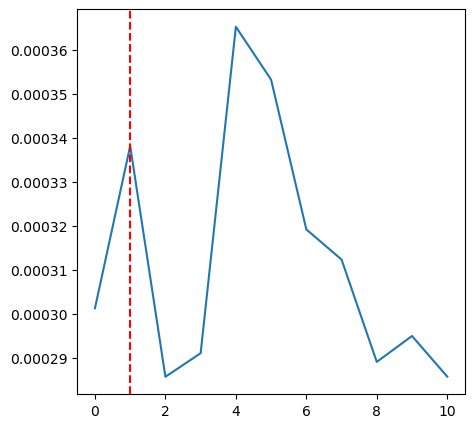

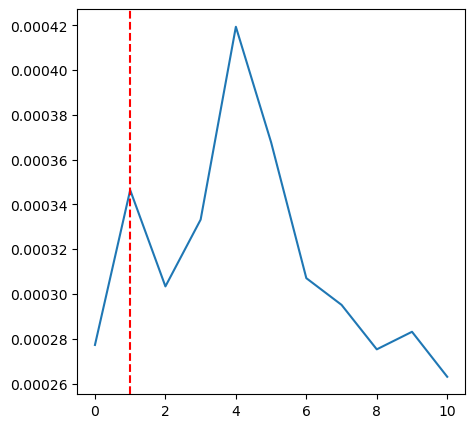

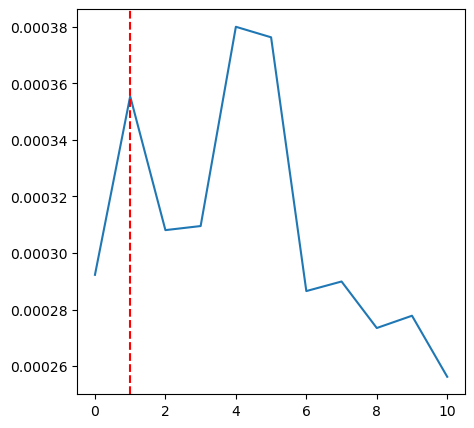

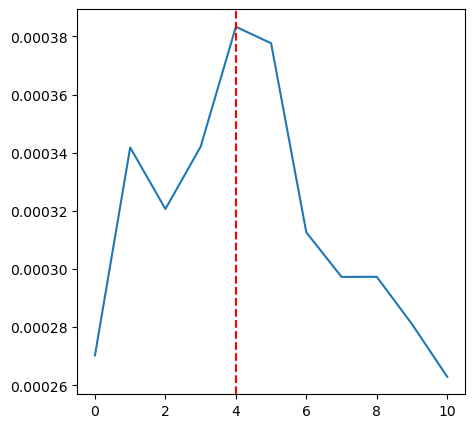

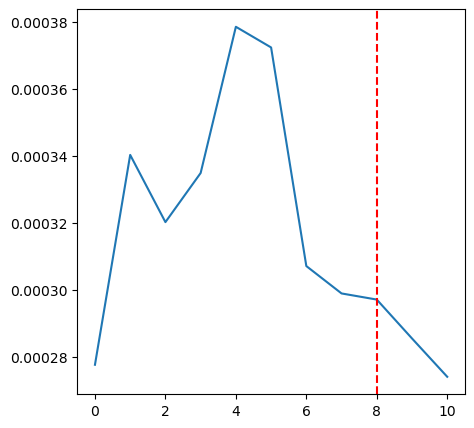

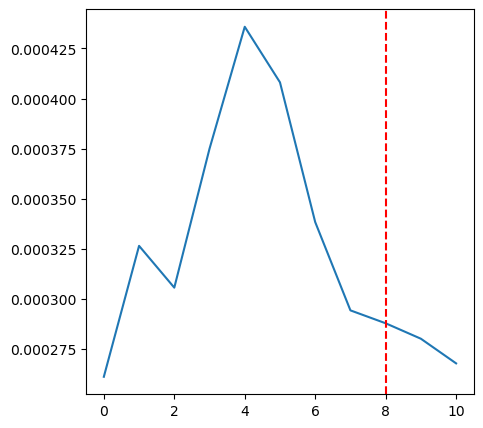

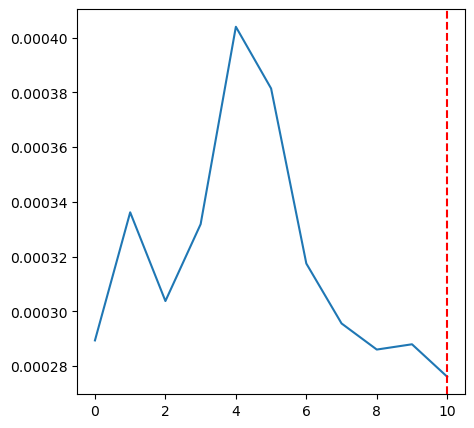

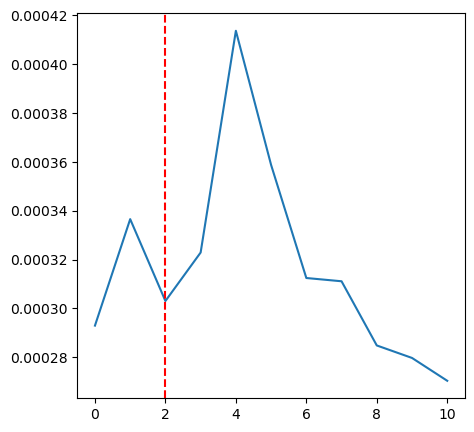

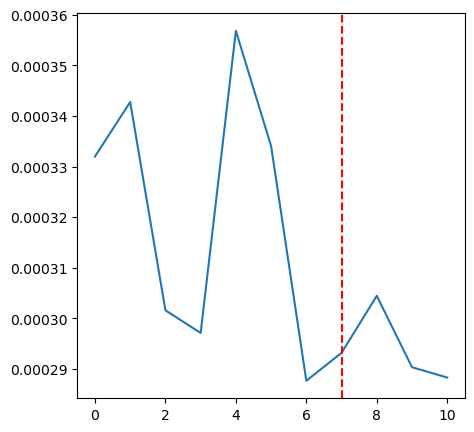

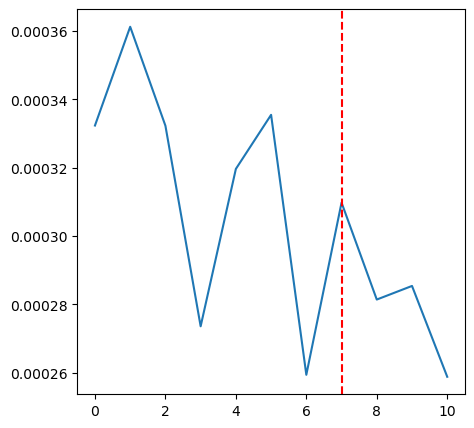

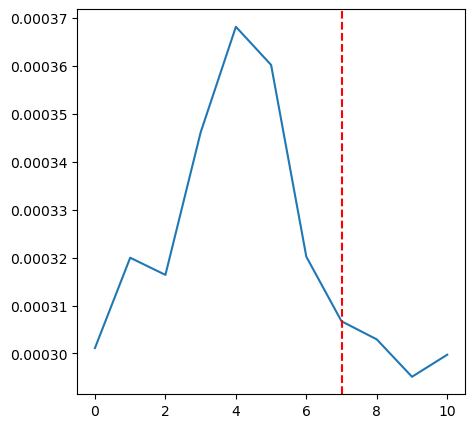

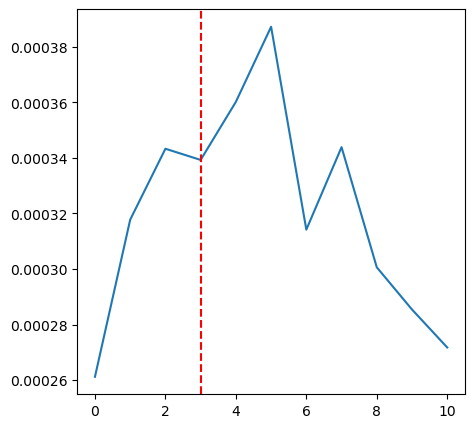

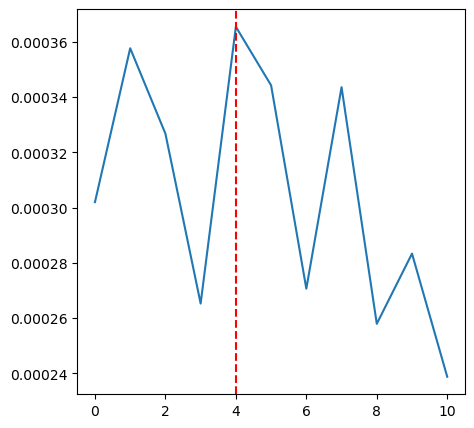

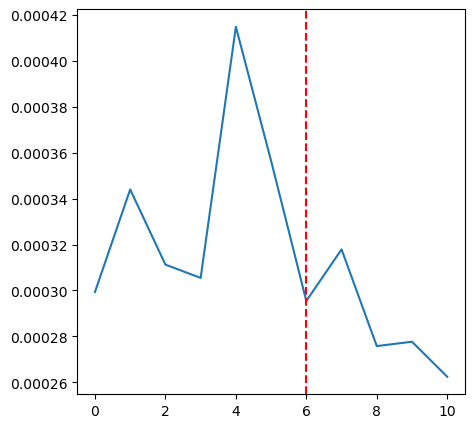

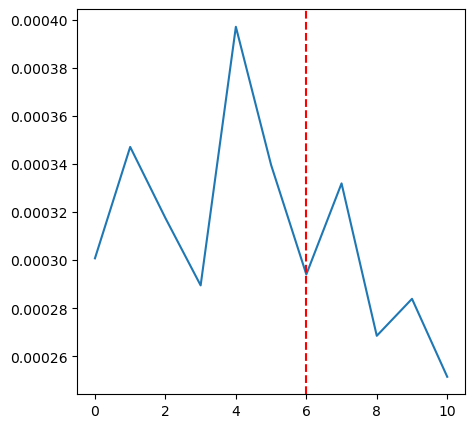

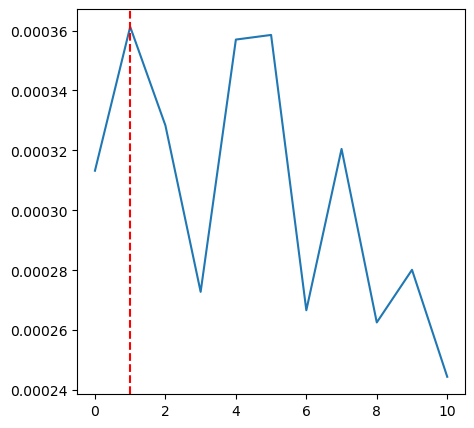

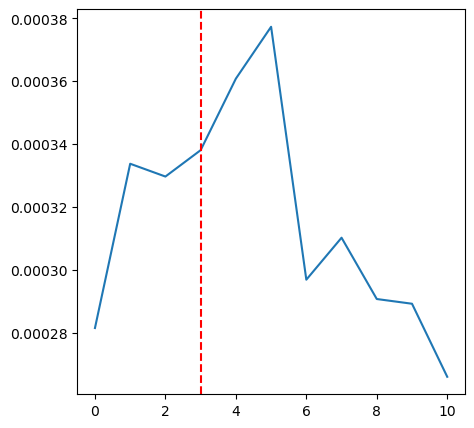

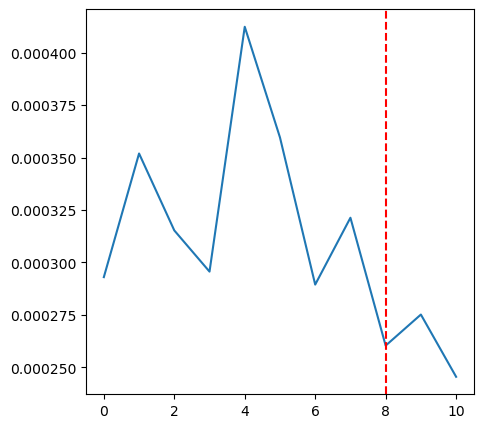

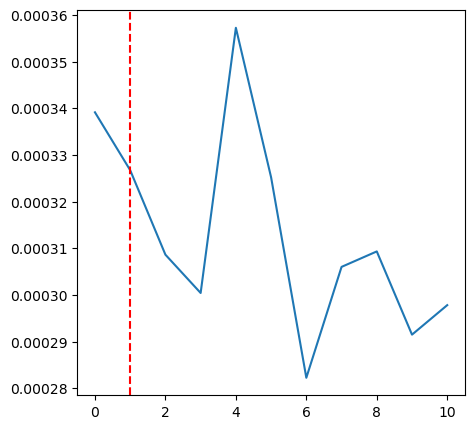

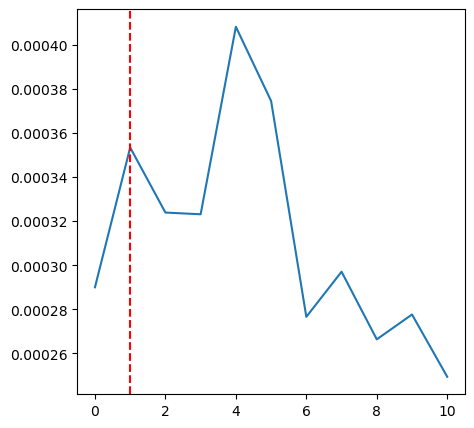

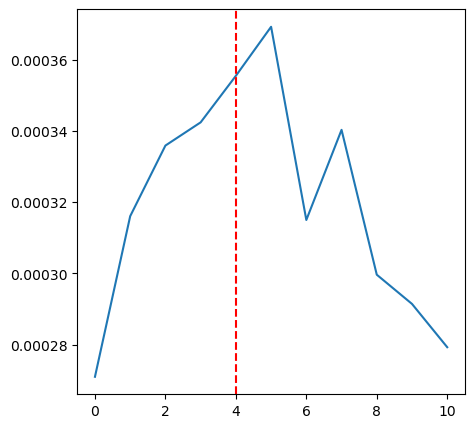

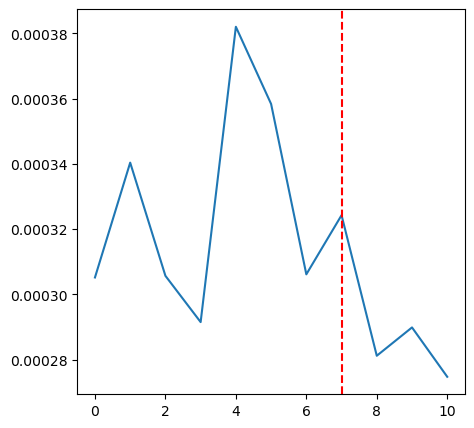

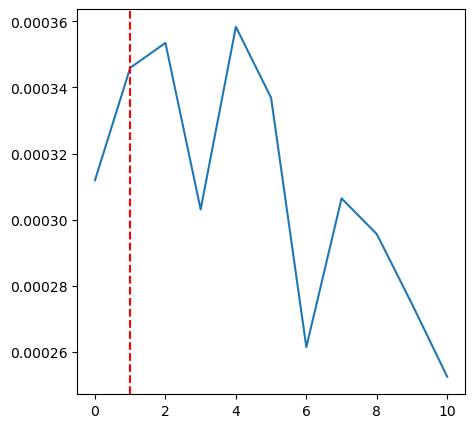

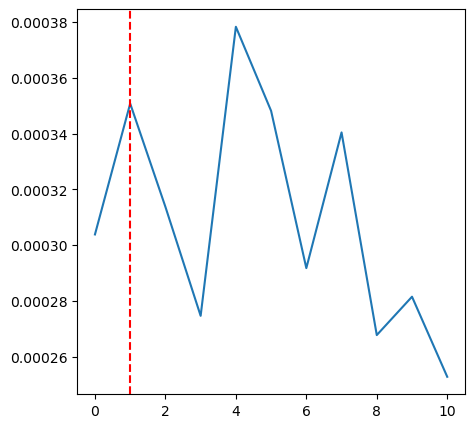

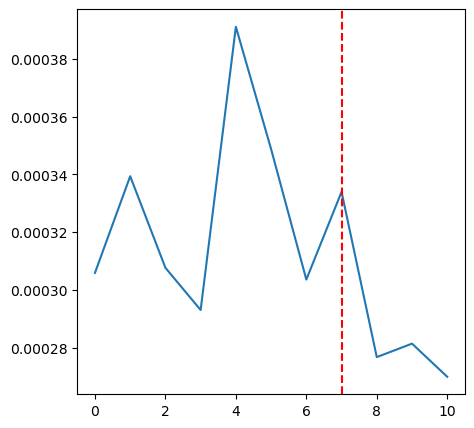

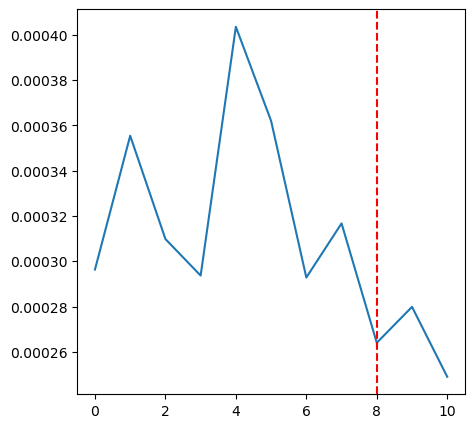

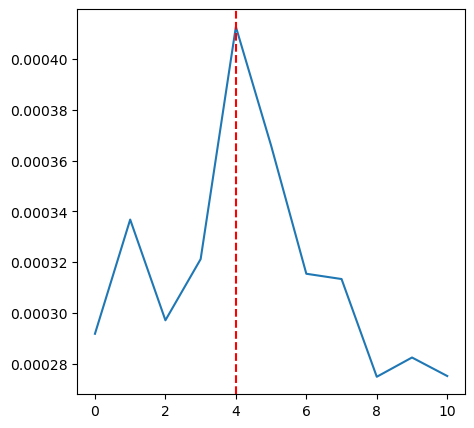

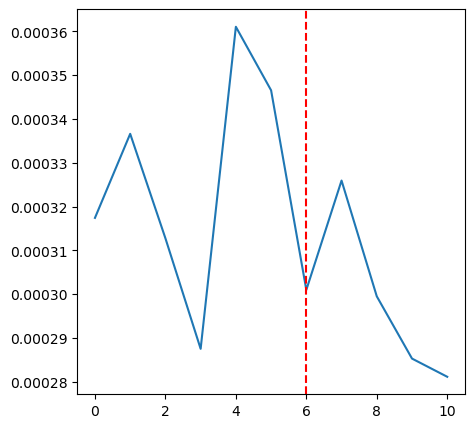

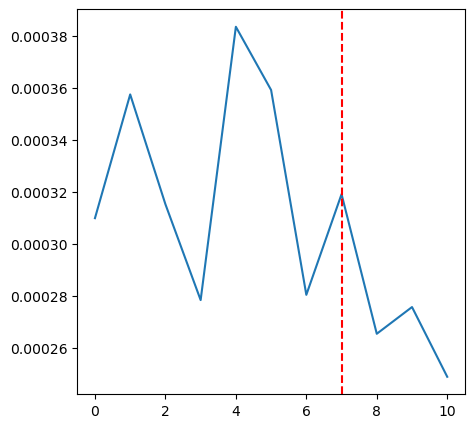

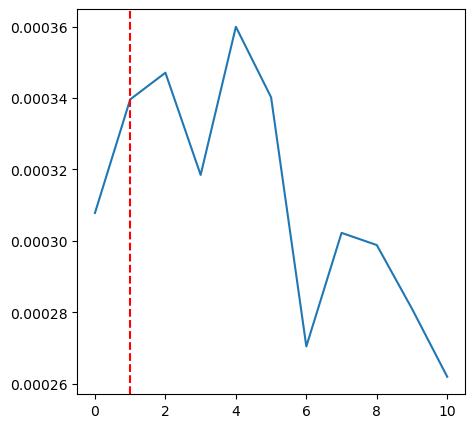

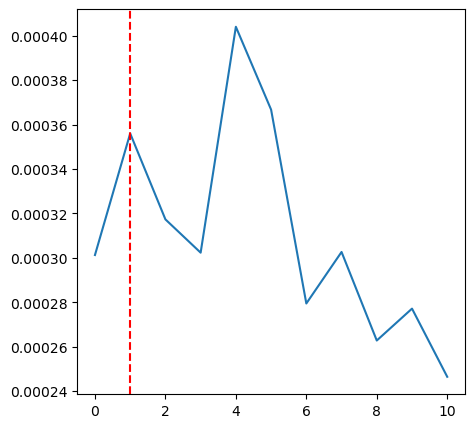

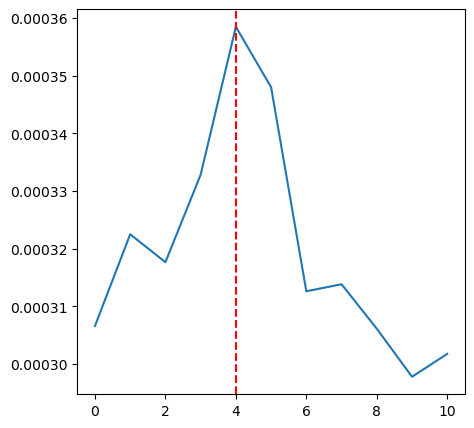

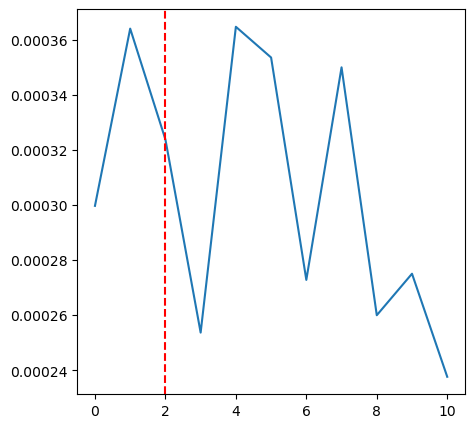

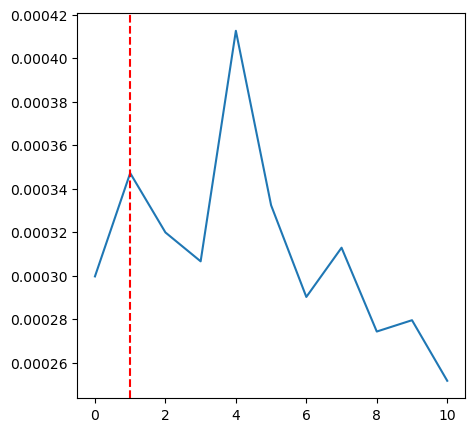

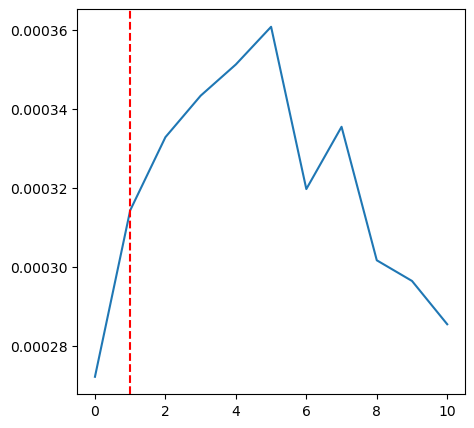

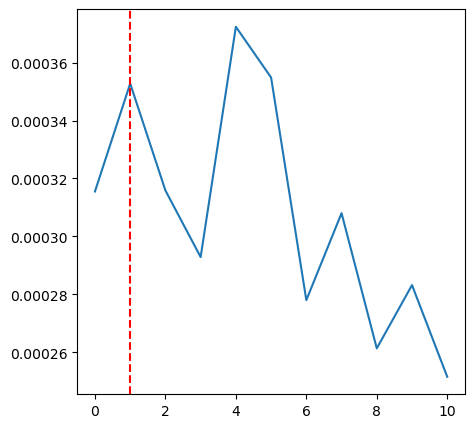

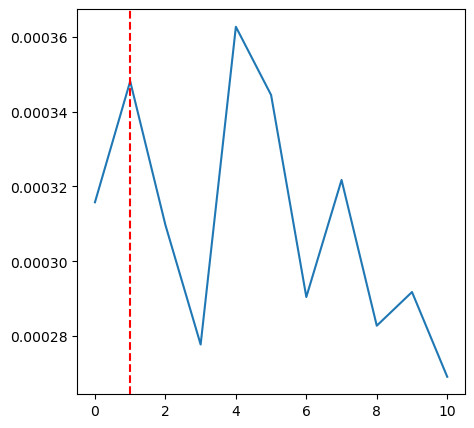

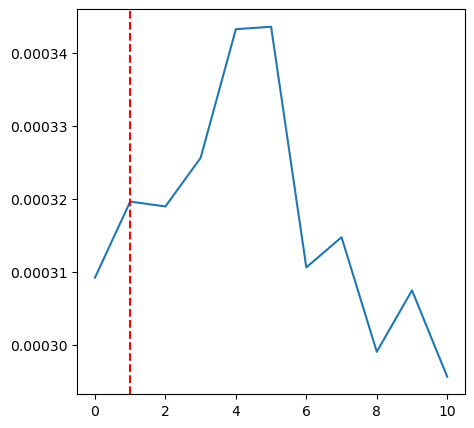

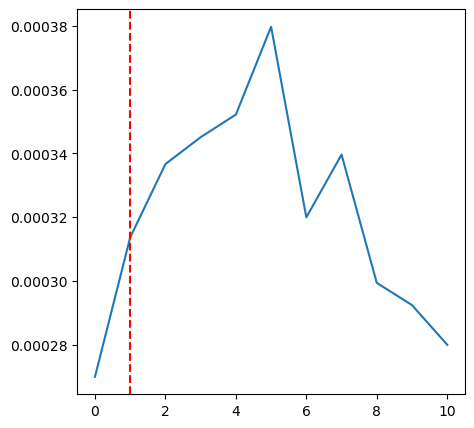

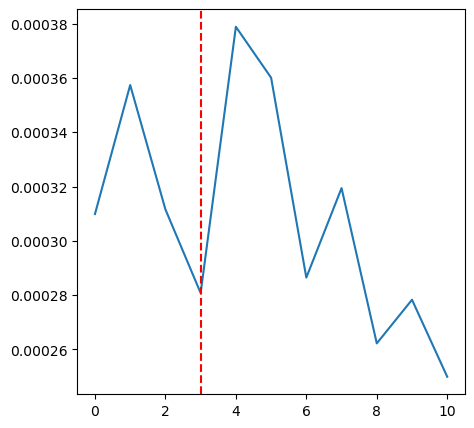

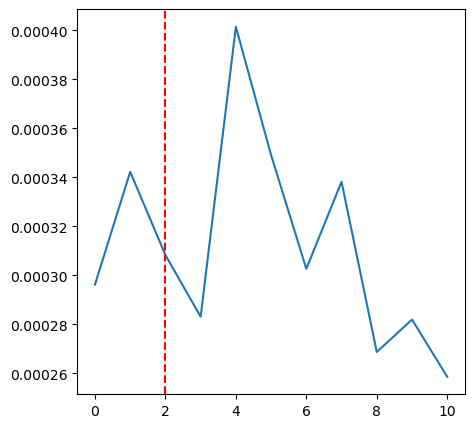

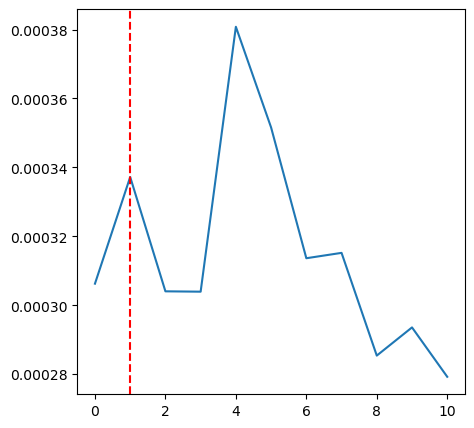

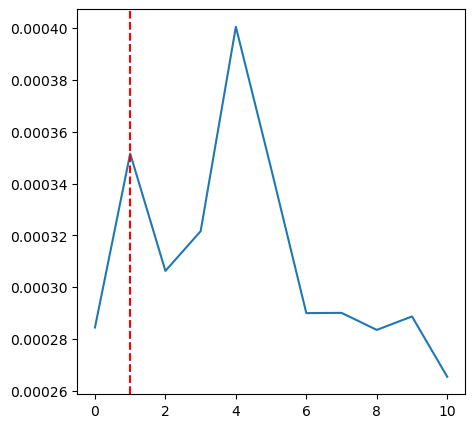

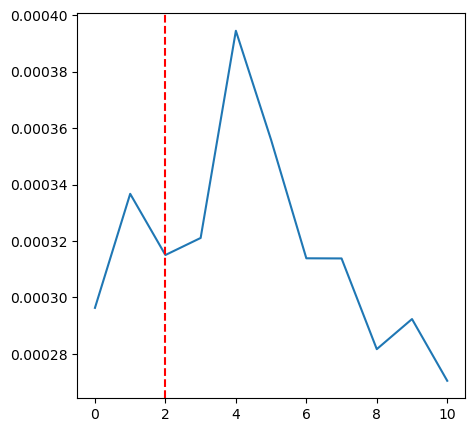

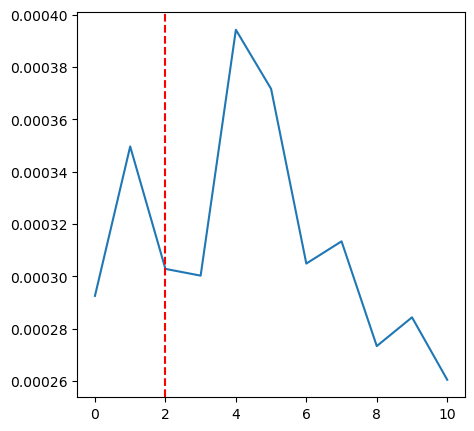

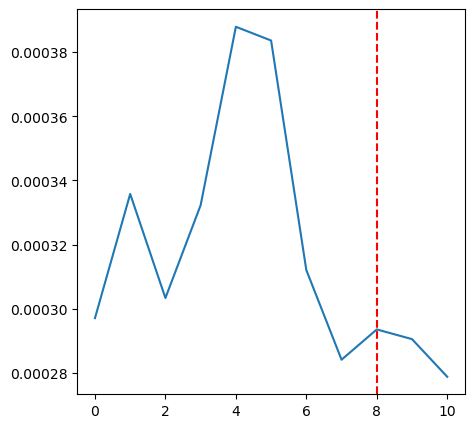

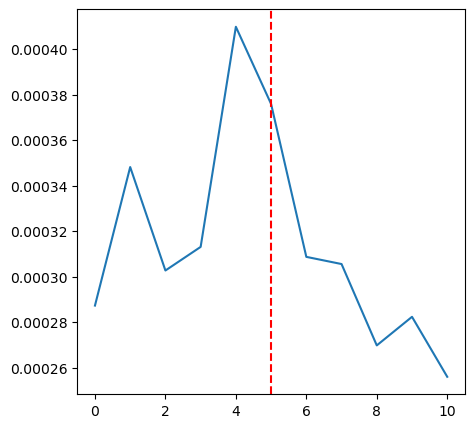

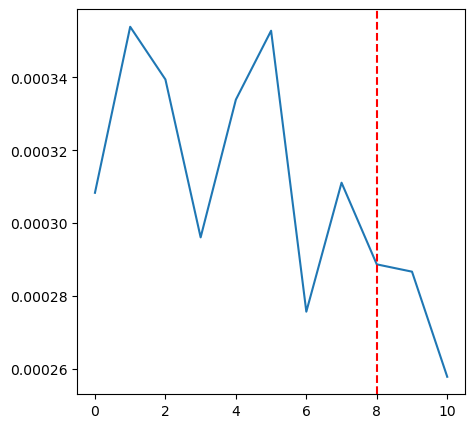

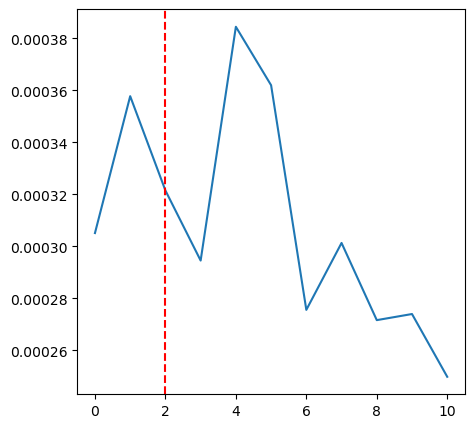

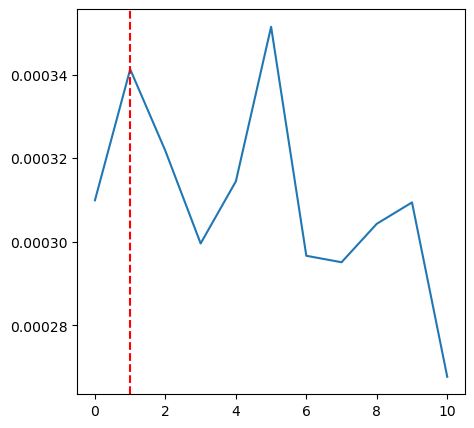

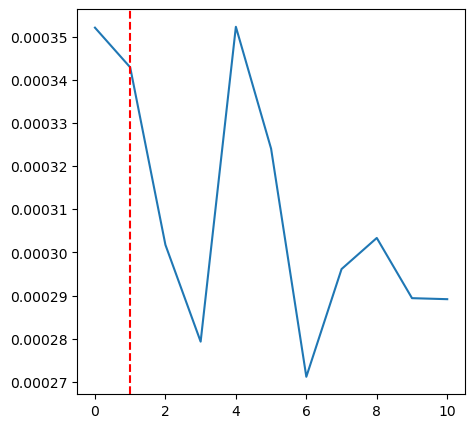

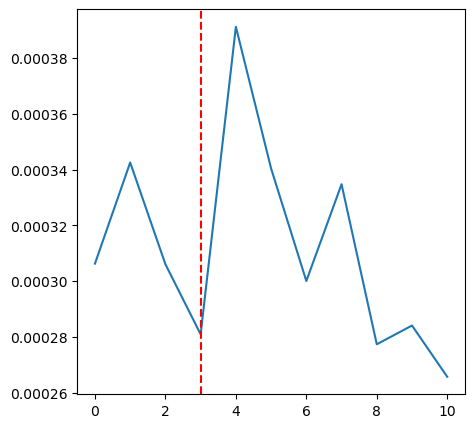

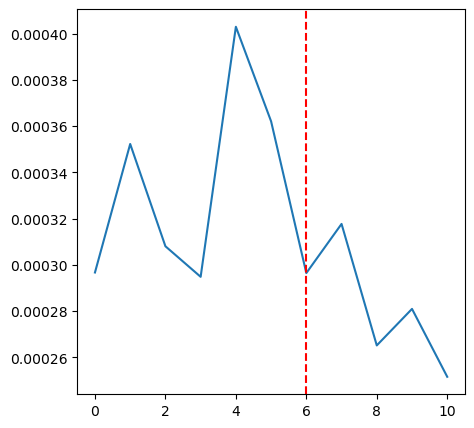

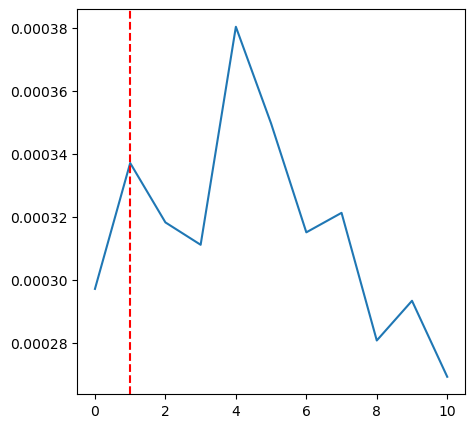

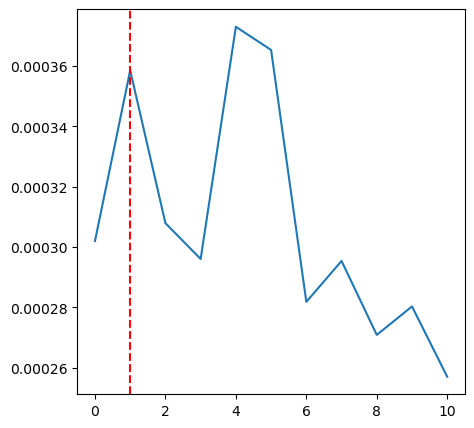

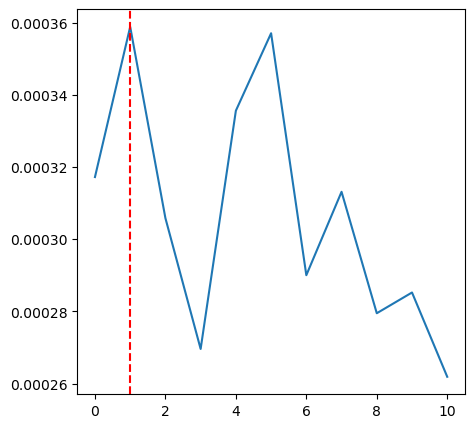

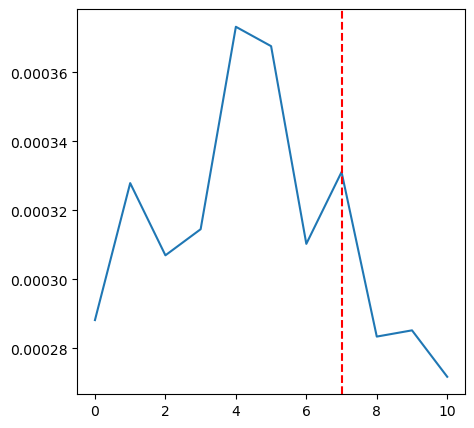

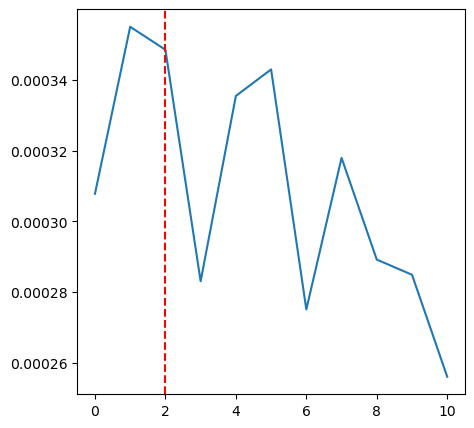

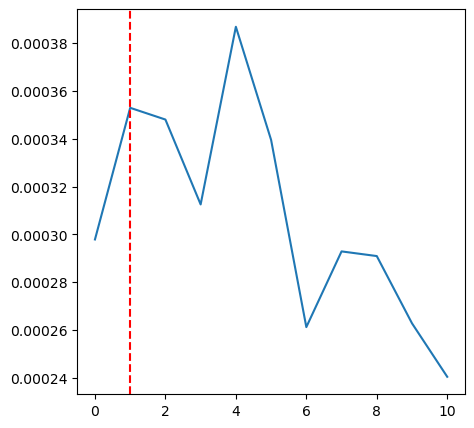

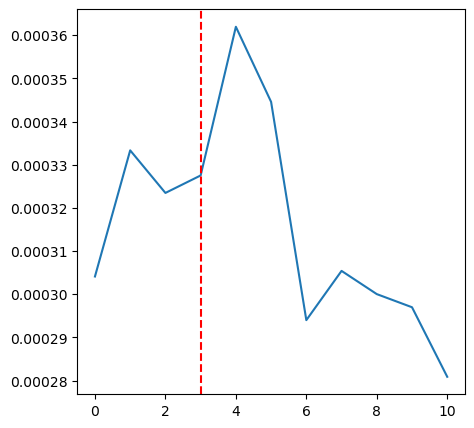

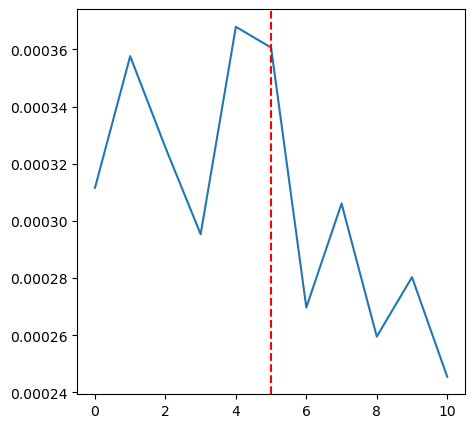

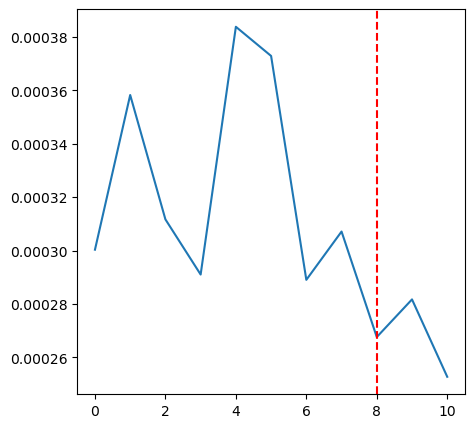

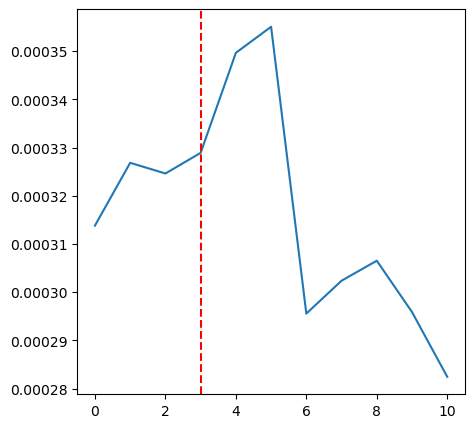

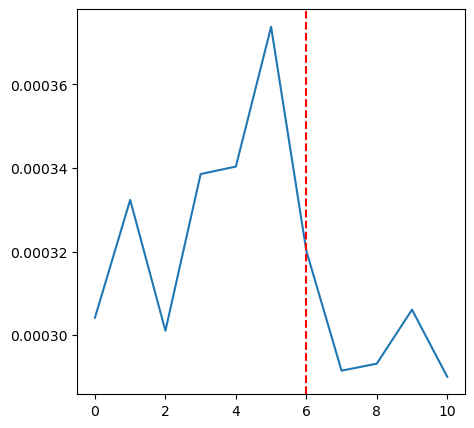

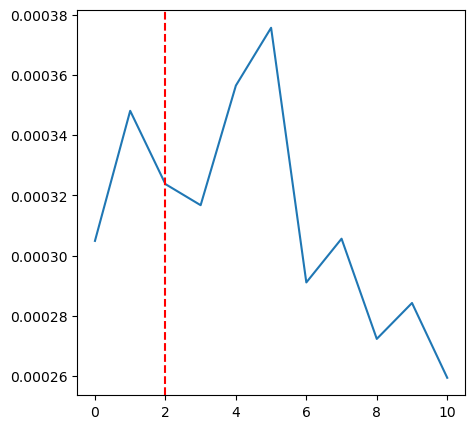

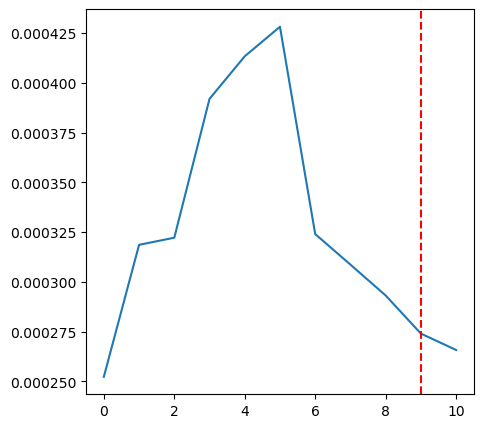

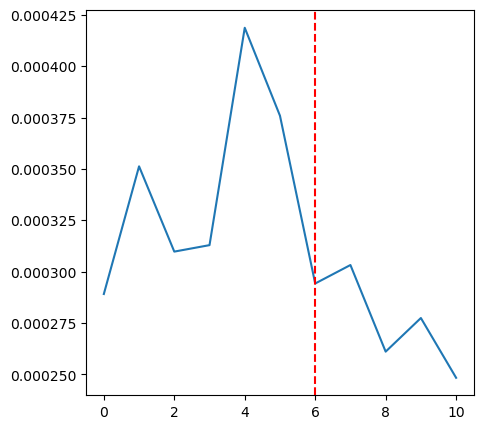

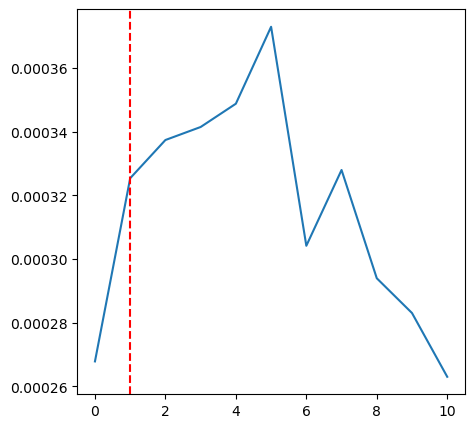

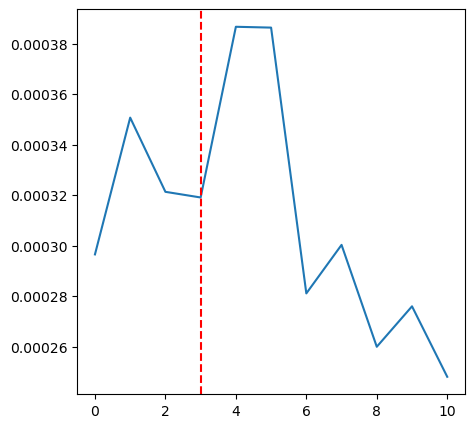

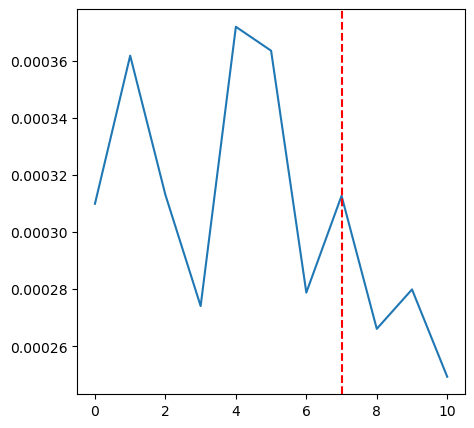

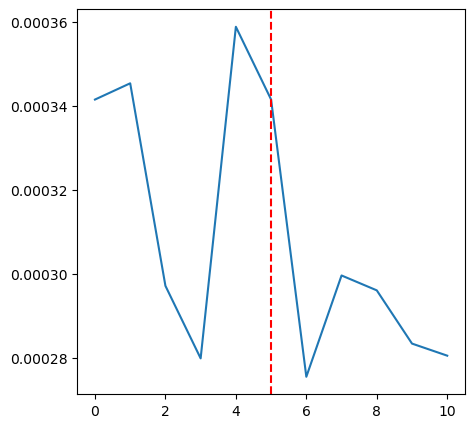

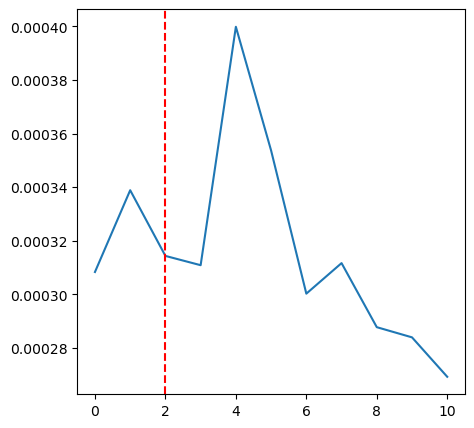

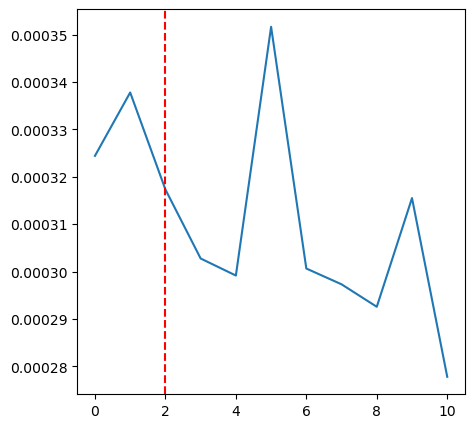

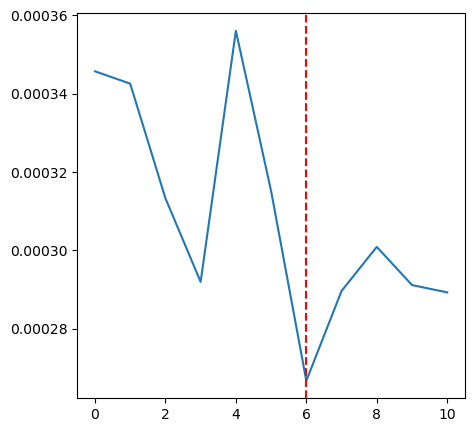

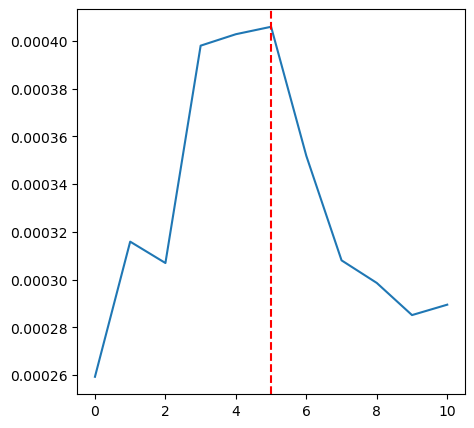

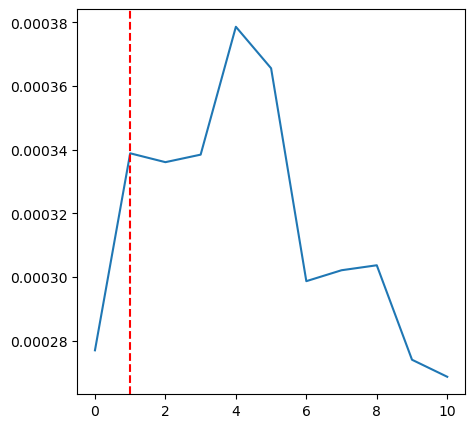

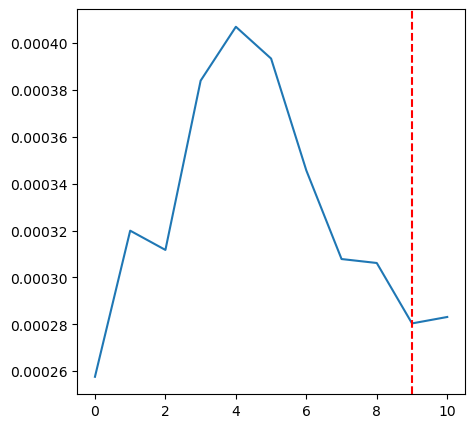

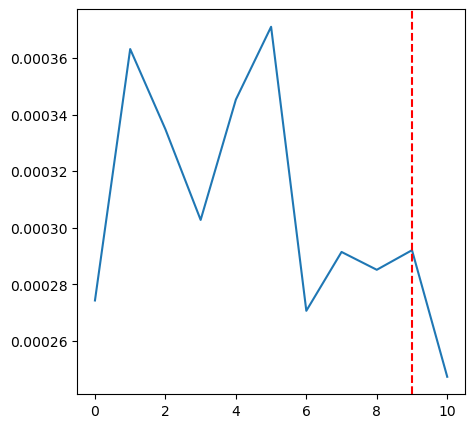

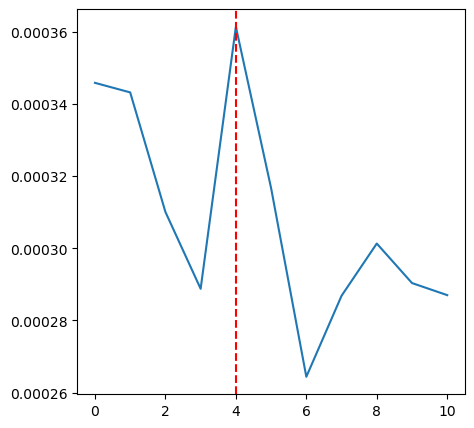

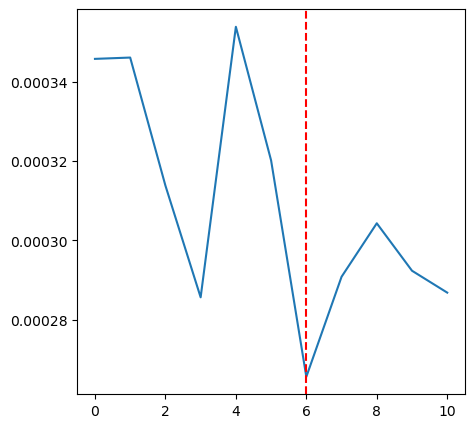

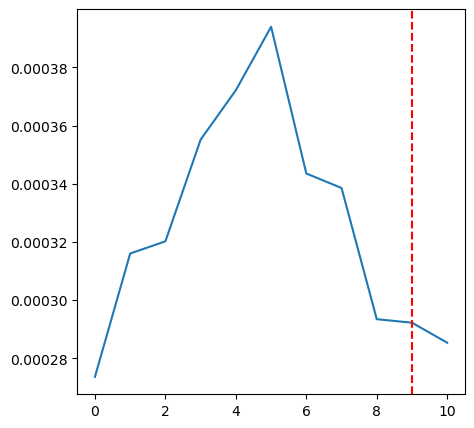

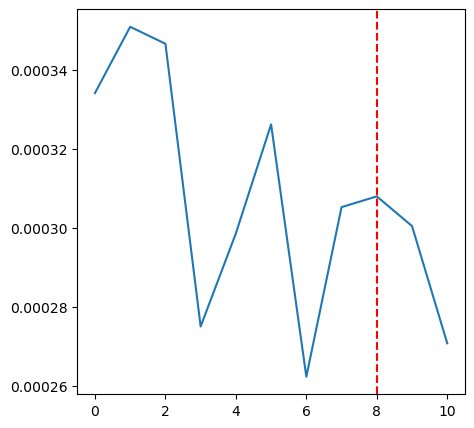

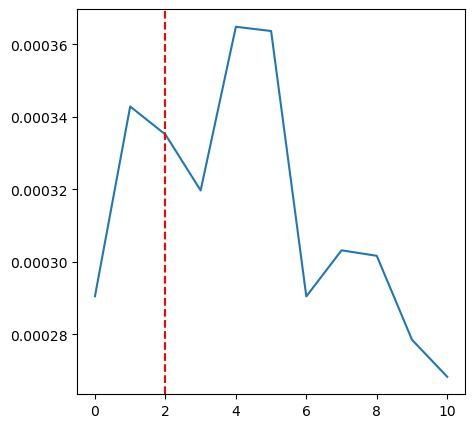

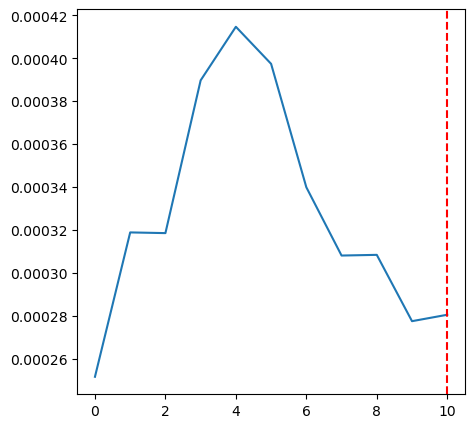

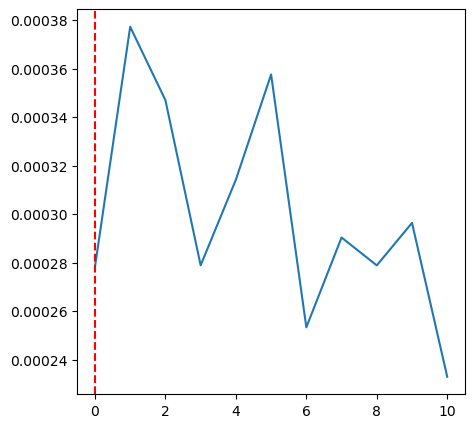

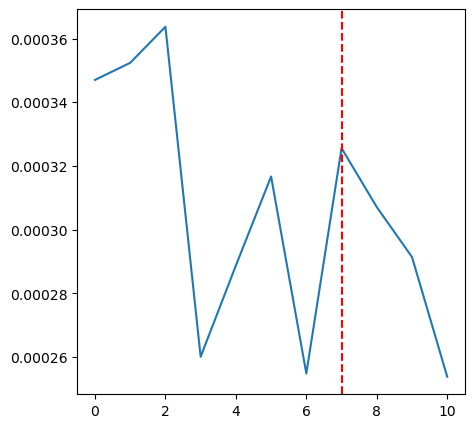

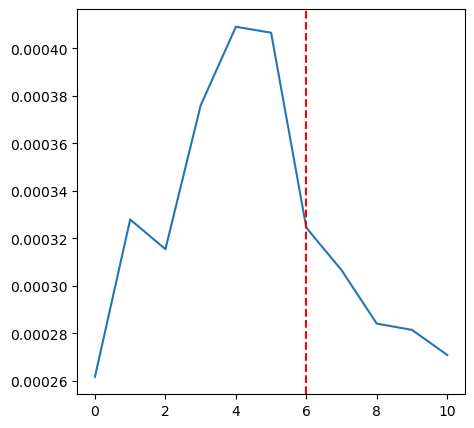

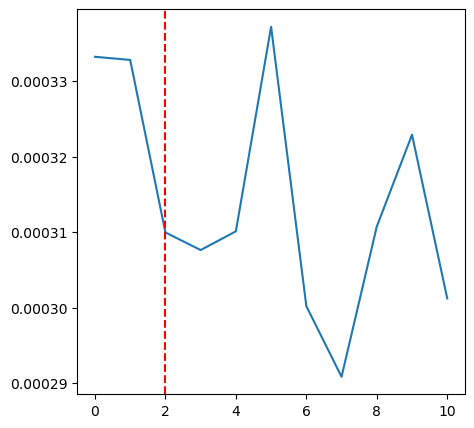

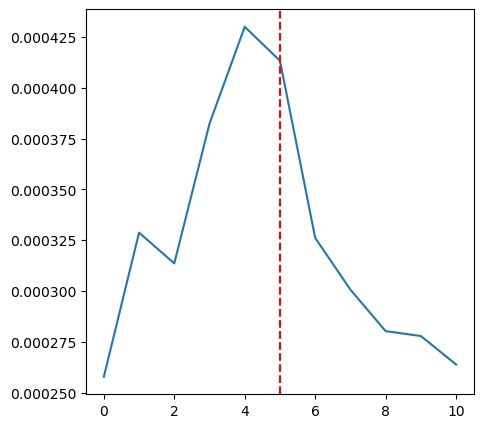

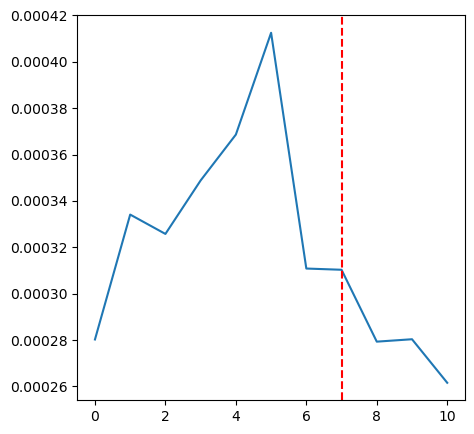

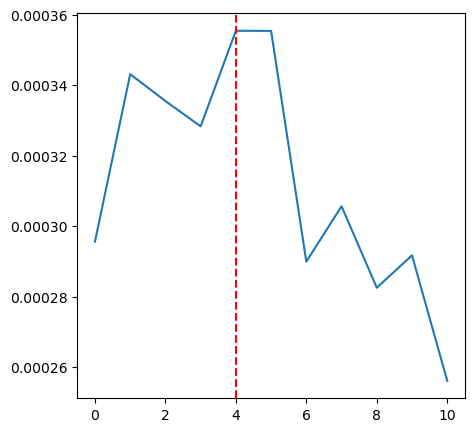

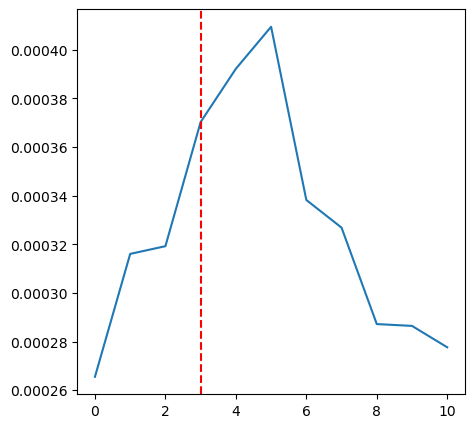

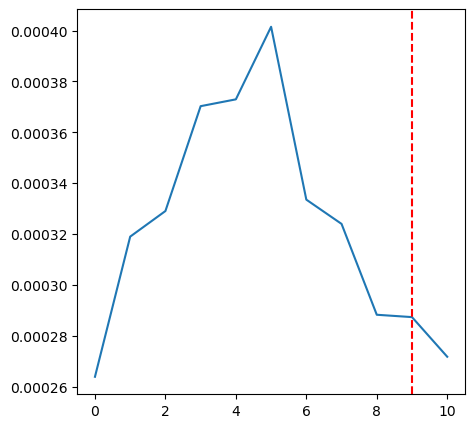

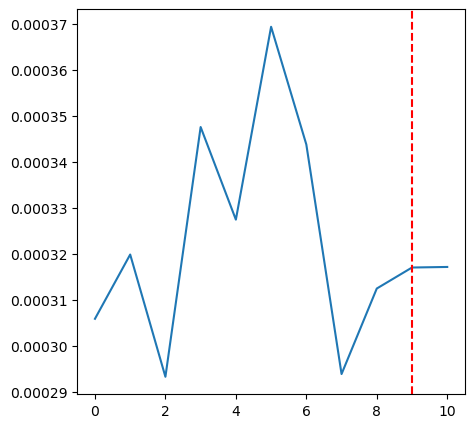

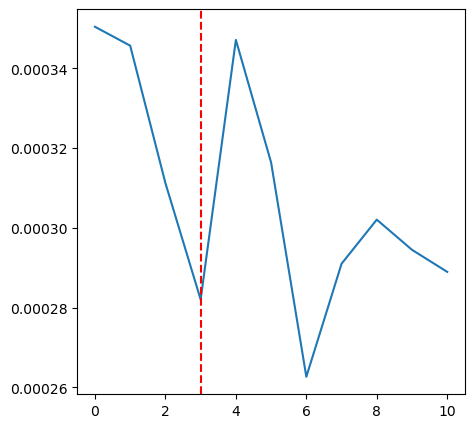

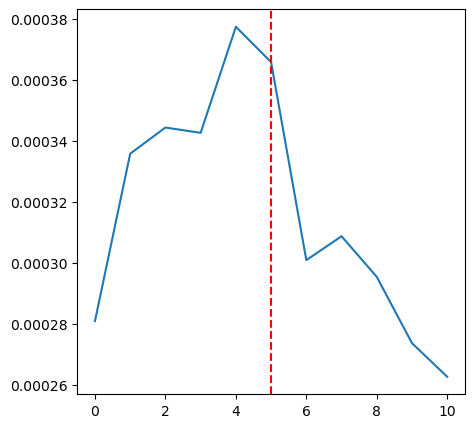

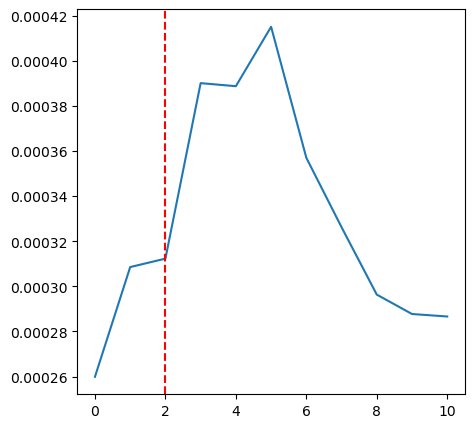

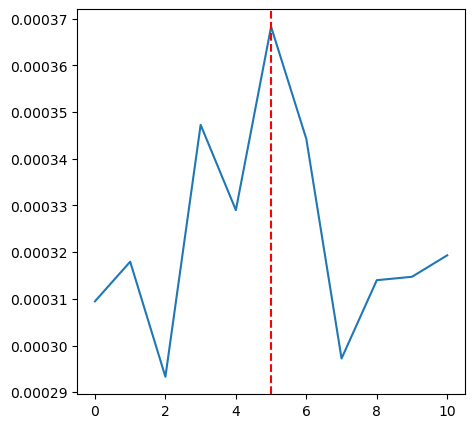

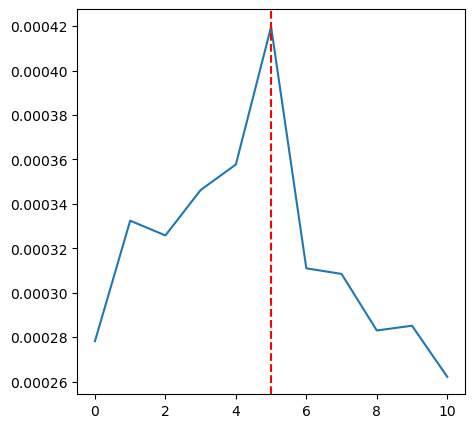

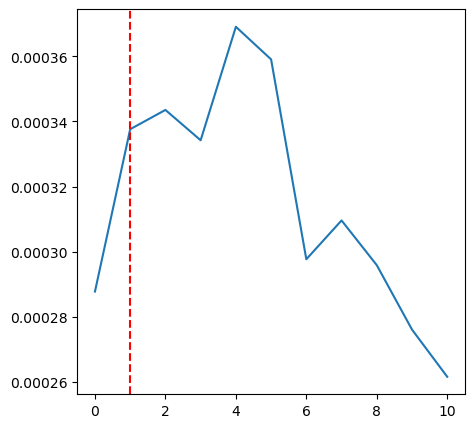

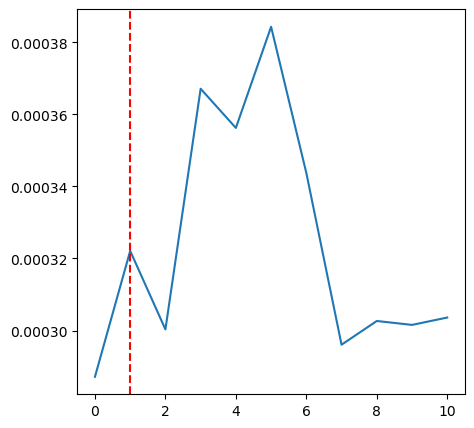

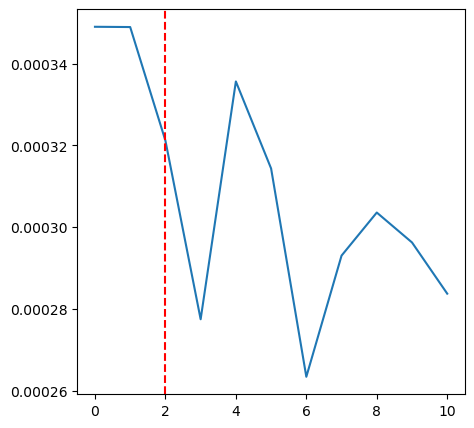

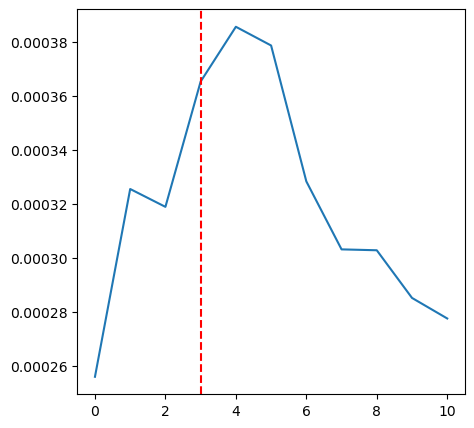

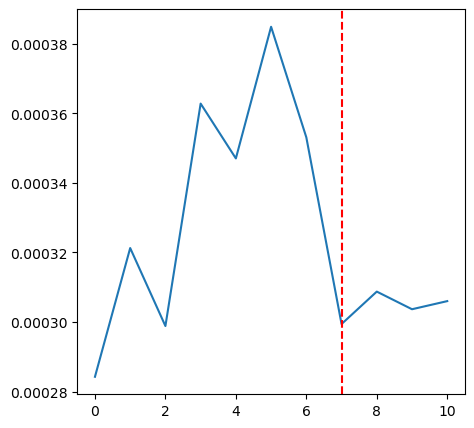

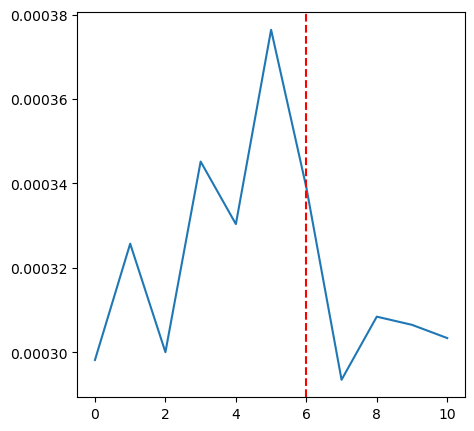

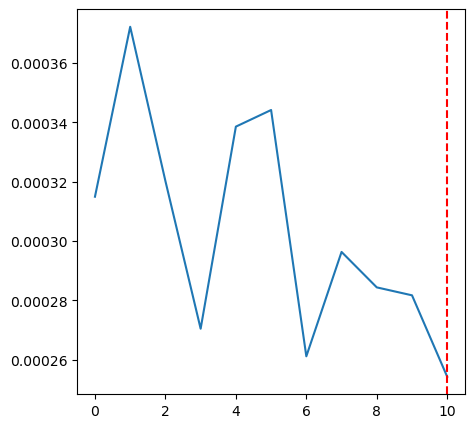

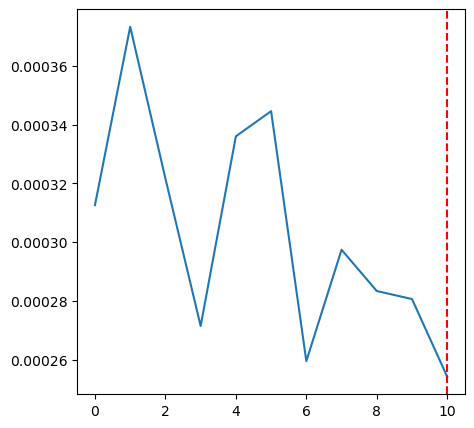

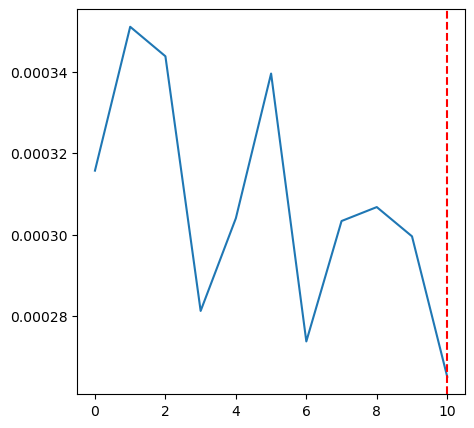

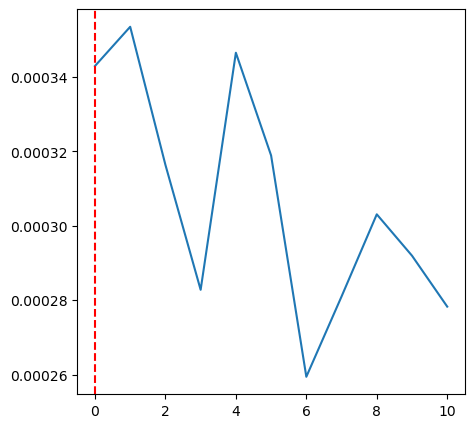

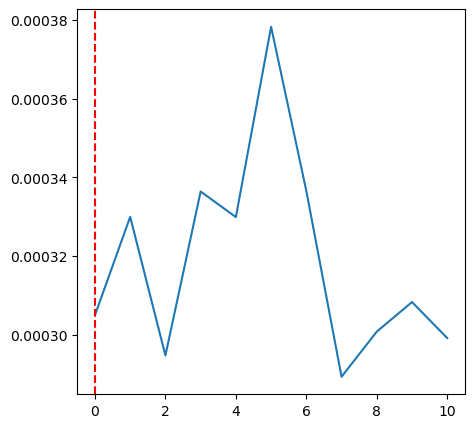

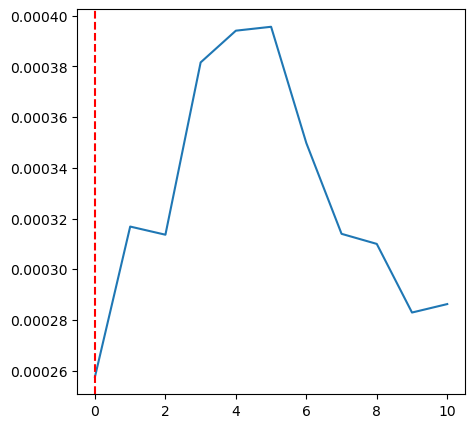

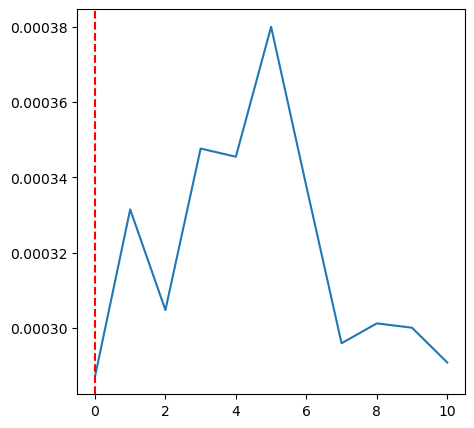

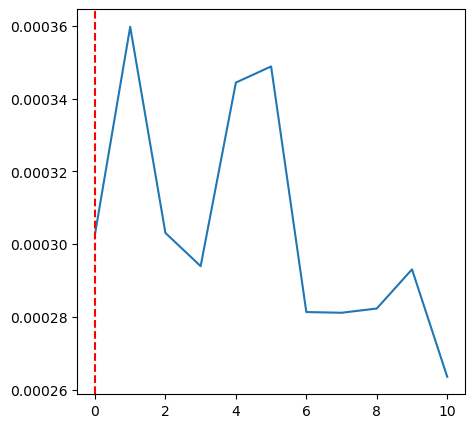

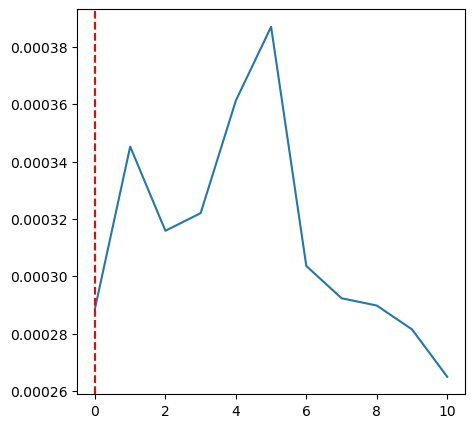

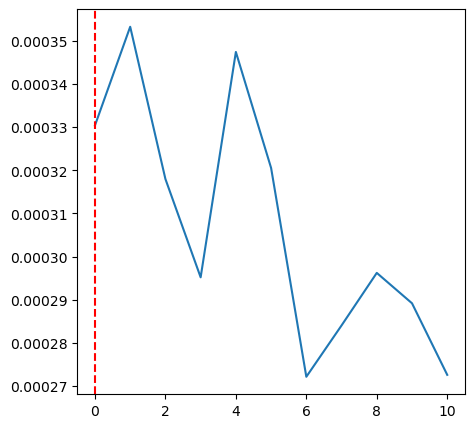

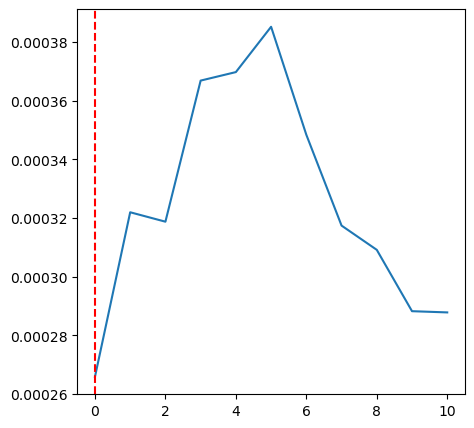

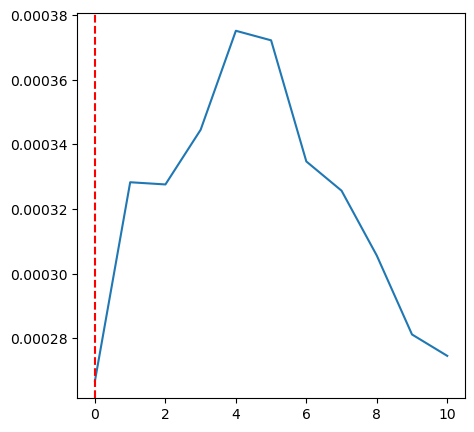

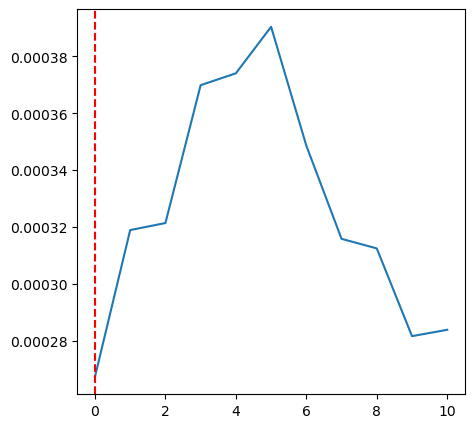

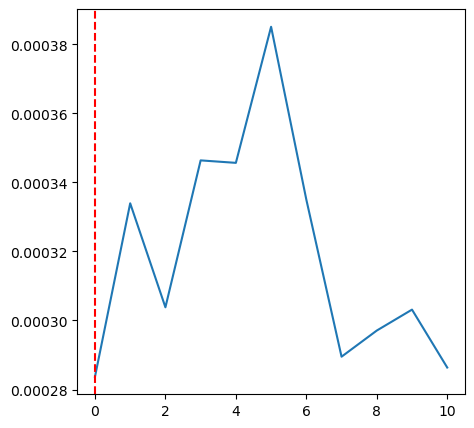

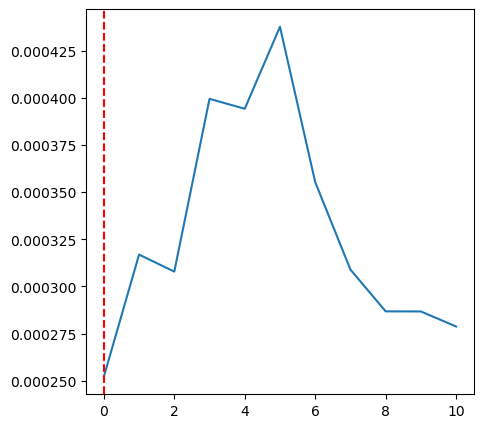

In [24]:
soft_logits = softmax(pred_SA_logits)
for i in range(len(soft_logits)):
    plt.figure(figsize=(5, 5))
    plt.plot(soft_logits[i])
    plt.axvline(native_SA[i], color='r', linestyle='--')
    plt.show()

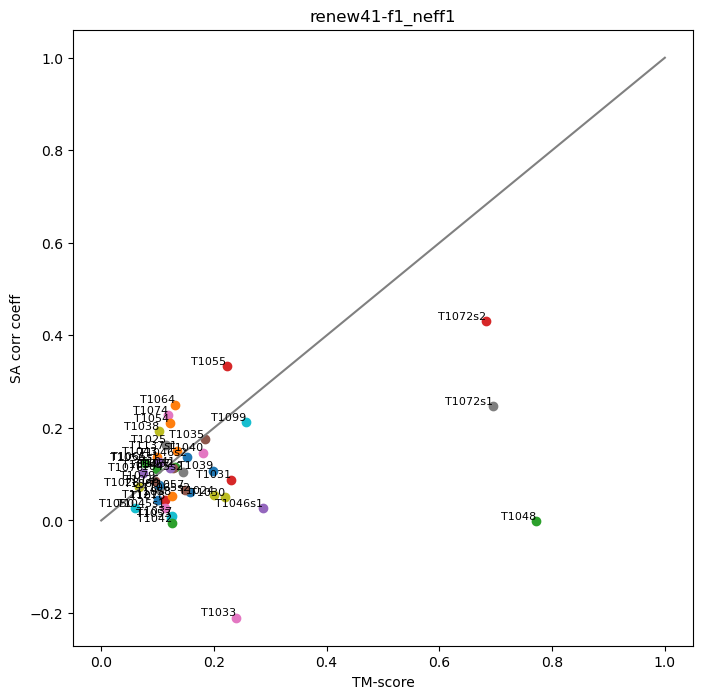

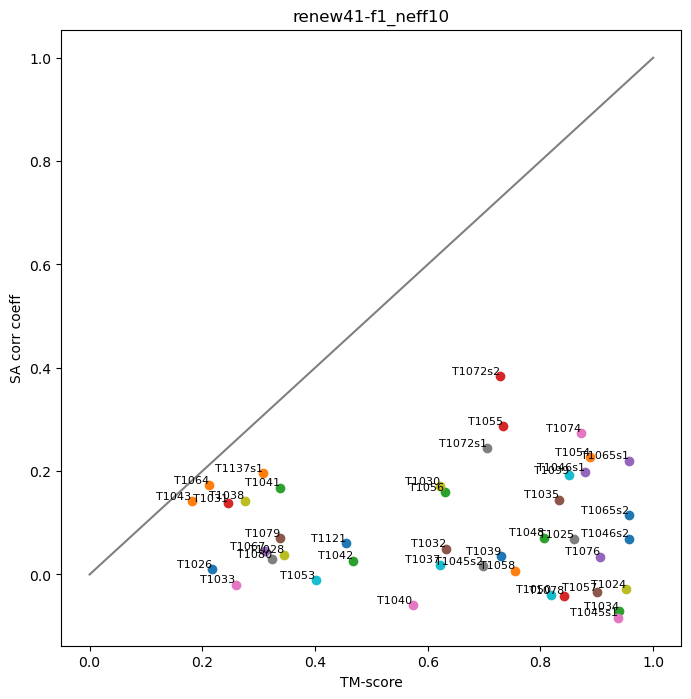

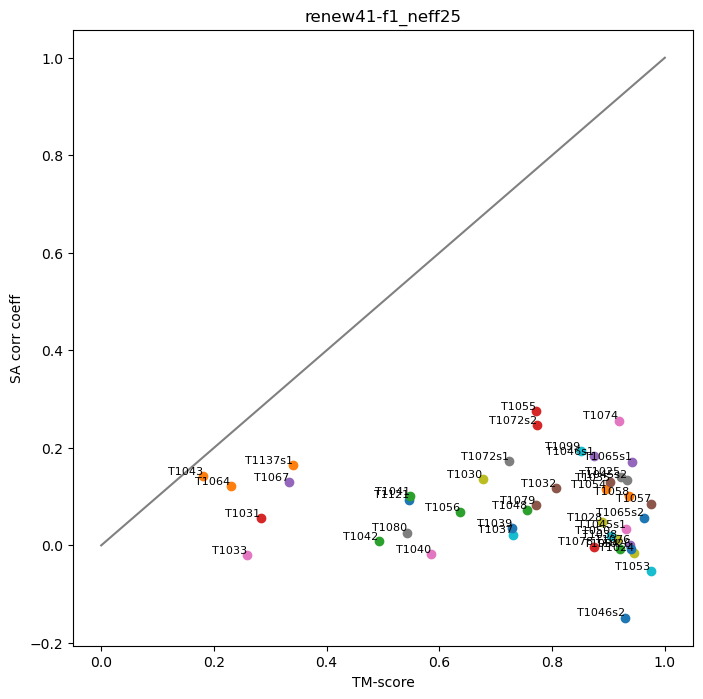

In [7]:
# Scatter plot

for i, model in enumerate(pred_paths.keys()):
    plt.figure(figsize=(8, 8))
    plt.title(model)
    for target in targets:
        plt.scatter(tmscores[model][target], solvents[model][target], label = model)

    plt.plot([0, 1], [0, 1], color='gray')
    plt.xlabel('TM-score')
    plt.ylabel(f'SA corr coeff')
    for target_name, x, y in zip(tmscores[model].keys(), tmscores[model].values(), solvents[model].values()):
        plt.text(x, y, target_name, fontsize=8, ha='right', va='bottom')
         #Show the plot
    #plt.legend()
    plt.show()

In [ ]:
np.array(list(solvents[model].values())).mean()